# Figure 6: MACM (SCALE) maps and spatial correspondence to parcellations

In [1]:
import os
import sys

import nimare
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches
from matplotlib.patches import Patch
import seaborn as sns
import nilearn.plotting, nilearn.maskers, nilearn.image
from nilearn.image import resample_to_img
from nilearn.plotting import plot_roi
import nilearn.surface
import nibabel

from pprint import pprint
import itertools
import scipy
import scipy.spatial
from tqdm import tqdm
import neuromaps
import itertools
from itertools import islice
import nimare_gpu
import SUITPy.flatmap
import brainspace.mesh, brainspace.plotting
import pyvirtualdisplay
import hcp_utils as hcp
from IPython.display import display
import tempfile
from nimare.meta.cbma.ale import ALE, SCALE
from nimare.utils import vox2mm, mm2vox
from nimare_gpu.ale import DeviceALE, DeviceSCALE, DeviceMixin
from nimare.correct import FWECorrector
import argparse
from numba import cuda
import json
import glob
import re
from tqdm import tqdm
import warnings
warnings.simplefilter('ignore')

# Define base directory of the project which is the parent of scripts folder
BASE_DIR = os.path.abspath('../..')
sys.path.append(os.path.join(BASE_DIR, 'scripts'))

import utils

# Defines input and output paths.
INPUT_DIR = os.path.join(BASE_DIR, 'input')
OUTPUT_DIR = os.path.join(BASE_DIR, 'output')
# create figures directory
FIGURES_DIR = os.path.join(OUTPUT_DIR, 'figures')
figure_dir = os.path.join(FIGURES_DIR, 'Figure6')
supplementary_dir = os.path.join(figure_dir, 'Supplementary')
os.makedirs(supplementary_dir, exist_ok=True)

# Set up font style
plt.rcParams["font.family"] = "Asana Math"
plt.rcParams["font.size"] = 14
plt.rcParams["figure.dpi"] = 300

pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


## Prepare global environment

In [2]:
# Obtain the number of experiments from the macm_exp_stats.csv
if os.path.exists(os.path.join(OUTPUT_DIR, 'macm_exp_stats.csv')):
    stats = pd.read_csv(os.path.join(OUTPUT_DIR, 'macm_exp_stats.csv'), index_col=0)
    # Keep only rows where 'n_exp' is greater than 15
    stats = stats[stats['n_exp'] > 15]
    # Display the filtered DataFrame
    print(stats)
else:
    stats = []  # Initialize stats as an empty list
    # Search for stats.json files in the specified directory structure
    for stats_path in glob.glob(os.path.join(OUTPUT_DIR, 'SALE', '*', '*', 'corr_cluster_h-001_k-50_mask-D2009_MNI_z_macm', 'stats.json')):
        # Use regular expression to extract the subbd value
        match = re.search(r'SALE/[^/]+/([^/]+)/[^/]+/stats\.json$', stats_path)
        if match:
            subbd = match.group(1)  # Extracted subbd value
        else:
            continue  # Skip to the next iteration if subbd is not found
        # Open and read the current stats.json file
        with open(stats_path, 'r') as f:
            curr_stats = json.load(f)
        # Add the subbd value to the current stats
        curr_stats['subbd'] = subbd
        stats.append(curr_stats)  # Append the current stats to the list
    # Convert the list of dictionaries to a DataFrame
    stats = pd.DataFrame(stats).set_index('subbd').sort_index()
    # Write the DataFrame to a CSV file
    stats.to_csv(os.path.join(OUTPUT_DIR, 'macm_exp_stats.csv'))
    # Keep only rows where 'n_exp' is greater than 17
    stats = stats[stats['n_exp'] > 17]
    # Display the filtered DataFrame
    print(stats)

                          n_exp  n_foci  n_subs
subbd                                          
Action                      197    3954    2656
Action.Execution            251    5195    3451
Action.Execution.Speech      80    1638    1096
Cognition.Memory.Working     21     345     353
Perception.Vision            34     553     467


In [3]:
# Define the domains and subdomains that are valid
domains = utils.domains_list
subdomains_with_domains = utils.subdomains_with_domains
# Get valid subbd values from the stats DataFrame
valid_subbd_values = stats.index.tolist()  # List of valid subbd values (domains in this case)
# Filter based on valid subbd values
filtered_domains = [domain for domain in domains if domain in valid_subbd_values]
filtered_subdomains = [subdomain for subdomain in subdomains_with_domains if subdomain in valid_subbd_values]
# Output the filtered lists
print("Filtered Domains:", filtered_domains)
print("Filtered Subdomains:", filtered_subdomains)

Filtered Domains: ['Action']
Filtered Subdomains: ['Action.Execution', 'Action.Execution.Speech', 'Cognition.Memory.Working', 'Perception.Vision']


In [4]:
# Get number of experiments for domains and subdomains
for domain in filtered_domains:
    if domain in stats.index:
        n_exp_value = stats.loc[domain, "n_exp"] 
        print(f"{domain}: {n_exp_value}")
    else:
        print(f"{domain} not found in stats.")
for subdomain in filtered_subdomains:
    if subdomain in stats.index:
        n_exp_value = stats.loc[subdomain, "n_exp"]
        print(f"{subdomain}: {n_exp_value}")
    else:
        print(f"{subdomain} not found in stats.")

Action: 197
Action.Execution: 251
Action.Execution.Speech: 80
Cognition.Memory.Working: 21
Perception.Vision: 34


In [5]:
subdomain_labels = utils.bd_labels
subdomain_labels

# Keep only labels where index matches stats
filtered_subdomain_labels = subdomain_labels[subdomain_labels.index.isin(stats.index)]

# Output the filtered subdomain_labels
print("Filtered Subdomain Labels:")
print(filtered_subdomain_labels)

Filtered Subdomain Labels:
Action                                Action
Action.Execution.Speech     Speech Execution
Action.Execution                   Execution
Cognition.Memory.Working      Working Memory
Perception.Vision                     Vision
dtype: object


In [6]:
# Fetch the FSLR meshes
meshes_fslr = {
    'L': str(neuromaps.datasets.fetch_fslr()['inflated'].L), 
    'R': str(neuromaps.datasets.fetch_fslr()['inflated'].R)
}

## 6b, e. Plot the MACM maps across the cerebral cortex

### 6b. Behavioral Domains

Binarized thresholded maps

In [7]:
# Iterate over each domain and construct file paths
for domain in filtered_domains:
    # Construct the file path for the current domain
    macm_nifti = os.path.join(OUTPUT_DIR, f'SALE/{domain}/{domain}/corr_cluster_h-001_k-50_mask-D2009_MNI_z_macm/corr_cluster_k-50_z.nii.gz')
    # Check if the file path exists
    if os.path.exists(macm_nifti):
        # Create the necessary directories for saving the figures
        macm_bin_figure_dir = os.path.join(supplementary_dir, 'Cerebrum', domain)
        os.makedirs(macm_bin_figure_dir, exist_ok=True)  # Create the directory if it does not exist
        # Binarize the NIfTI image
        macm_bin = nilearn.image.binarize_img(macm_nifti)
        # Define the full path for the figure file
        macm_bin_figure = os.path.join(macm_bin_figure_dir, f'{domain}_MACM_Cerebral-Cortex-Surface_p001_K50-binarized')
        # Create a temporary file for the binarized image
        tmp_filename = tempfile.mktemp('.nii.gz')
        macm_bin.to_filename(tmp_filename)
        # Transform from MNI152 to FSLR
        macm_bin_fslr = neuromaps.transforms.mni152_to_fslr(tmp_filename, method='linear')
        macm_bin_fslr = np.concatenate([macm_bin_fslr[0].agg_data(), macm_bin_fslr[1].agg_data()])
        # Display the surface plot
        display(utils.plot_surface(macm_bin_fslr, meshes_fslr, filename=macm_bin_figure, cmap='Reds', nan_color=(1, 1, 1, 1)))
    else:
        print(f"File path does not exist for domain: {domain}. Skipping...")

'/data/project/cerebellum_ale/public/output/figures/Figure6/Supplementary/Cerebrum/Action/Action_MACM_Cerebral-Cortex-Surface_p001_K50-binarized.png'

### 6e. Subdomains

Thresholded (binarized)

In [8]:
# Iterate over each domain and construct file paths
for domain in domains:
    for subdomain in filtered_subdomains:
        # Construct the file path for the current domain
        macm_nifti = os.path.join(OUTPUT_DIR, f'SALE/{domain}/{subdomain}/corr_cluster_h-001_k-50_mask-D2009_MNI_z_macm/corr_cluster_k-50_z.nii.gz')
        # Check if the file path exists
        if os.path.exists(macm_nifti):
            # Create the necessary directories for saving the figures
            macm_bin_figure_dir = os.path.join(supplementary_dir, 'Cerebrum', domain, subdomain)
            os.makedirs(macm_bin_figure_dir, exist_ok=True)  # Create the directory if it does not exist
            # Binarize the NIfTI image
            macm_bin = nilearn.image.binarize_img(macm_nifti)
            # Define the full path for the figure file
            macm_bin_figure = os.path.join(macm_bin_figure_dir, f'{subdomain}_MACM_Cerebral-Cortex-Surface_p001_K50-binarized')
            # Create a temporary file for the binarized image
            tmp_filename = tempfile.mktemp('.nii.gz')
            macm_bin.to_filename(tmp_filename)
            # Transform from MNI152 to FSLR
            macm_bin_fslr = neuromaps.transforms.mni152_to_fslr(tmp_filename, method='linear')
            macm_bin_fslr = np.concatenate([macm_bin_fslr[0].agg_data(), macm_bin_fslr[1].agg_data()])
            # Display the surface plot
            display(utils.plot_surface(macm_bin_fslr, meshes_fslr, filename=macm_bin_figure, cmap='Reds', nan_color=(1, 1, 1, 1)))
        else:
            print(f"File path does not exist for domain: {subdomain}. Skipping...")

'/data/project/cerebellum_ale/public/output/figures/Figure6/Supplementary/Cerebrum/Action/Action.Execution/Action.Execution_MACM_Cerebral-Cortex-Surface_p001_K50-binarized.png'

'/data/project/cerebellum_ale/public/output/figures/Figure6/Supplementary/Cerebrum/Action/Action.Execution.Speech/Action.Execution.Speech_MACM_Cerebral-Cortex-Surface_p001_K50-binarized.png'

File path does not exist for domain: Cognition.Memory.Working. Skipping...
File path does not exist for domain: Perception.Vision. Skipping...
File path does not exist for domain: Action.Execution. Skipping...
File path does not exist for domain: Action.Execution.Speech. Skipping...


'/data/project/cerebellum_ale/public/output/figures/Figure6/Supplementary/Cerebrum/Cognition/Cognition.Memory.Working/Cognition.Memory.Working_MACM_Cerebral-Cortex-Surface_p001_K50-binarized.png'

File path does not exist for domain: Perception.Vision. Skipping...
File path does not exist for domain: Action.Execution. Skipping...
File path does not exist for domain: Action.Execution.Speech. Skipping...
File path does not exist for domain: Cognition.Memory.Working. Skipping...
File path does not exist for domain: Perception.Vision. Skipping...
File path does not exist for domain: Action.Execution. Skipping...
File path does not exist for domain: Action.Execution.Speech. Skipping...
File path does not exist for domain: Cognition.Memory.Working. Skipping...
File path does not exist for domain: Perception.Vision. Skipping...
File path does not exist for domain: Action.Execution. Skipping...
File path does not exist for domain: Action.Execution.Speech. Skipping...
File path does not exist for domain: Cognition.Memory.Working. Skipping...


'/data/project/cerebellum_ale/public/output/figures/Figure6/Supplementary/Cerebrum/Perception/Perception.Vision/Perception.Vision_MACM_Cerebral-Cortex-Surface_p001_K50-binarized.png'

## 6a. Cerebral parcellation (Ji et al. 2019)

In [9]:
ca_colors = list(hcp.ca_network['rgba'].values())
ca_colors[0][3]=1
ca_cmap = LinearSegmentedColormap.from_list('CA', ca_colors, 13)
plt.register_cmap('CA', ca_cmap) # You only have to do this once

In [10]:
ca_ctx = hcp.cortex_data(hcp.ca_network['map_all'])

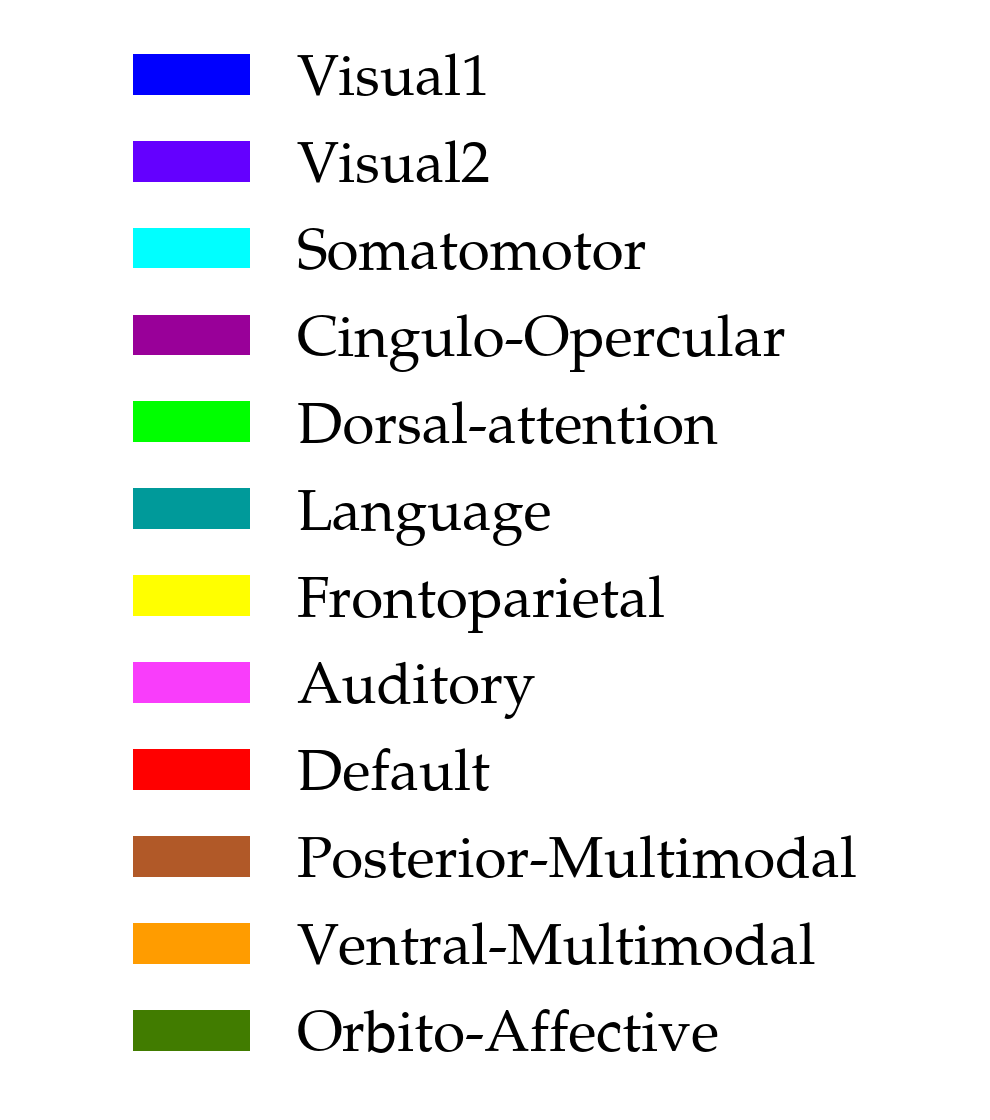

In [11]:
# Plot the parcellation
utils.plot_surface(ca_ctx, meshes_fslr, cmap='CA', filename= os.path.join(figure_dir, '6a_Ji_cerebral_network_parcellation'))

# Create the legend
ca_labels = list(hcp.ca_network['labels'].values())[1:]
colors = dict(zip(ca_labels, ca_colors[1:]))
# create legend handles
legend_handles = [
    mpatches.Patch(facecolor=colors[label], edgecolor="none", label=label) for label in colors
]
# create a figure for the legend
plt.figure(figsize=(4, 2))
# add the legend to the figure
plt.legend(handles=legend_handles, fontsize=14, loc="center", frameon=False)
# remove the axis
plt.axis("off")
# save the plot
plt.savefig(os.path.join(figure_dir, '6a_Ji_cerebral_network_parcellation-legend.png'), dpi=300, bbox_inches='tight')
# show the plot
plt.show()

## S16c. Calculate number of significant vertices for each MACM analysis within each cerebral network (Ji et al. 2019)

In [16]:
counts = {}

# Loop through the paths using glob and tqdm for progress tracking
for macm_path in tqdm(sorted(glob.glob(
    os.path.join(OUTPUT_DIR,'SALE/*/*/corr_cluster_h-001_k-50_mask-D2009_MNI_z_macm/corr_cluster_k-50_z.nii.gz')
))):
    # Use regular expression to extract the subdomain (subbd) from the path
    match = re.search(r'SALE/[^/]+/([^/]+)/corr_cluster_h-001_k-50_mask-D2009_MNI_z_macm/corr_cluster_k-50_z\.nii\.gz$', macm_path)
    if match:
        subbd = match.group(1)  # Extracted subdomain name
        # Check if subbd is in filtered_domains or filtered_subdomains
        if subbd not in filtered_domains and subbd not in filtered_subdomains:
            print(f"{subbd} not in filtered_domains or filtered_subdomains, skipping.")
            continue  # Skip to the next iteration if subbd is not in either list
    else:
        print(f"Pattern not matched for path: {macm_path}")
        continue  # Skip to the next iteration if no match is found

    # Binarize the MACM map
    macm_bin = nilearn.image.binarize_img(macm_path)
    # Transform to fsLR
    tfile = tempfile.mktemp('.nii.gz')
    macm_bin.to_filename(tfile)
    macm_fslr_gii = neuromaps.transforms.mni152_to_fslr(tfile, method='nearest')
    macm_fslr = np.concatenate([
        macm_fslr_gii[0].agg_data().flatten(),
        macm_fslr_gii[1].agg_data().flatten()
    ])

    # Check if there are any significant cortical MACM regions
    if macm_fslr.sum() == 0:
        print(subbd, "has no significant cortical MACM vertices")
        continue
    counts[subbd] = pd.DataFrame({
        'macm': macm_fslr.astype(bool),
        'ca': ca_ctx
    }).groupby('macm')['ca'].value_counts(sort=False)[(True, slice(None))]

counts = pd.DataFrame(counts).fillna(0)
counts = counts[(counts != 0).any(axis=1)].dropna(how='all')
# Calculate percentages
ca_pct = (counts / counts.values.sum(axis=0, keepdims=True)) * 100 

 17%|██████████████▊                                                                          | 2/12 [00:00<00:04,  2.19it/s]

Action.Observation not in filtered_domains or filtered_subdomains, skipping.


 33%|█████████████████████████████▋                                                           | 4/12 [00:01<00:02,  3.14it/s]

Cognition.Language not in filtered_domains or filtered_subdomains, skipping.


 50%|████████████████████████████████████████████▌                                            | 6/12 [00:01<00:01,  3.60it/s]

Cognition.SocialCognition not in filtered_domains or filtered_subdomains, skipping.
Emotion.Negative.Sadness not in filtered_domains or filtered_subdomains, skipping.
Perception.Somesthesis not in filtered_domains or filtered_subdomains, skipping.
Perception.Vision.Motion not in filtered_domains or filtered_subdomains, skipping.
Perception.Vision.Shape not in filtered_domains or filtered_subdomains, skipping.


100%|████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  5.18it/s]


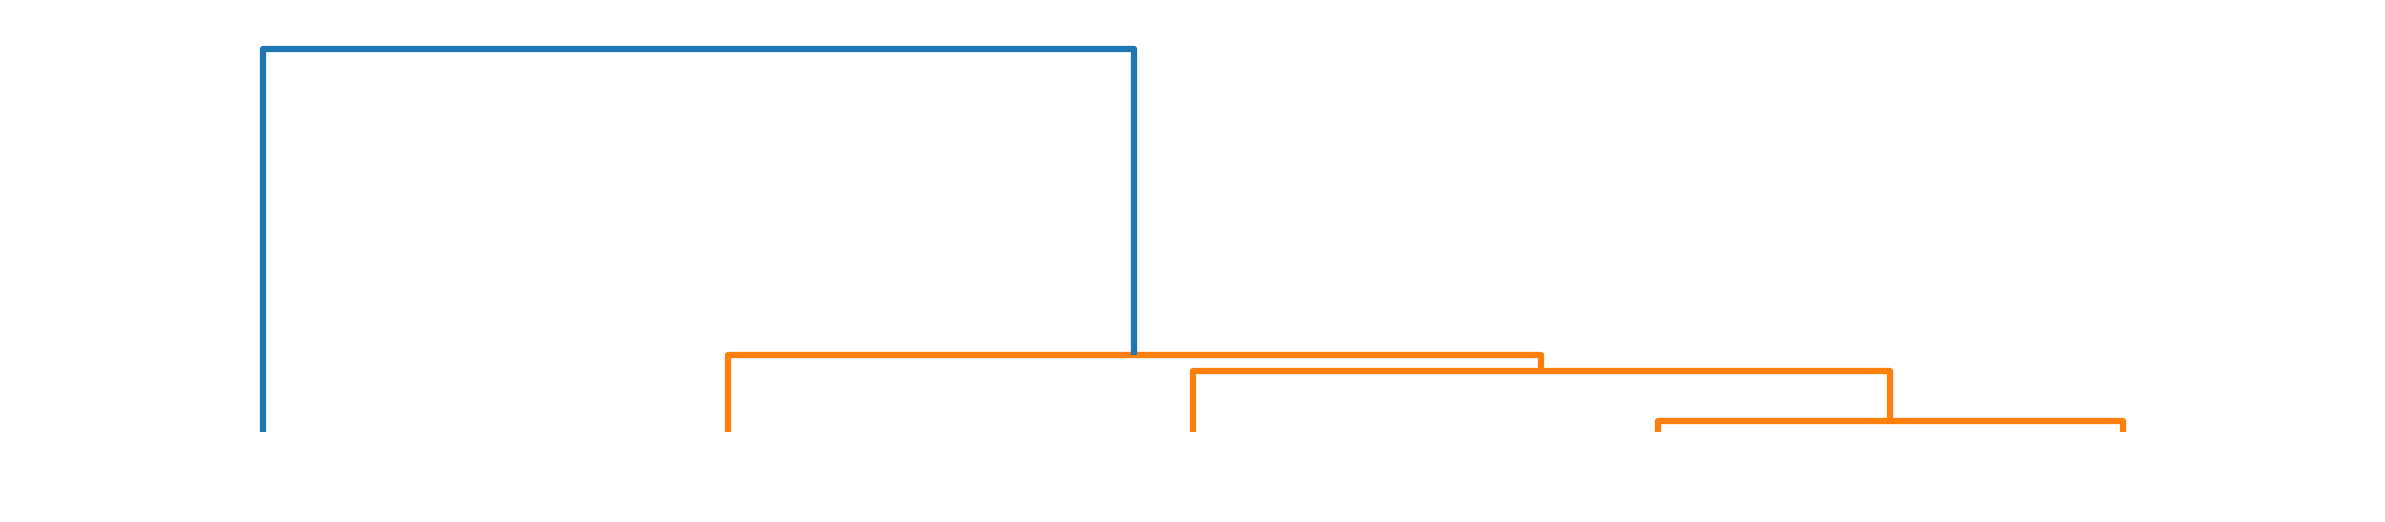

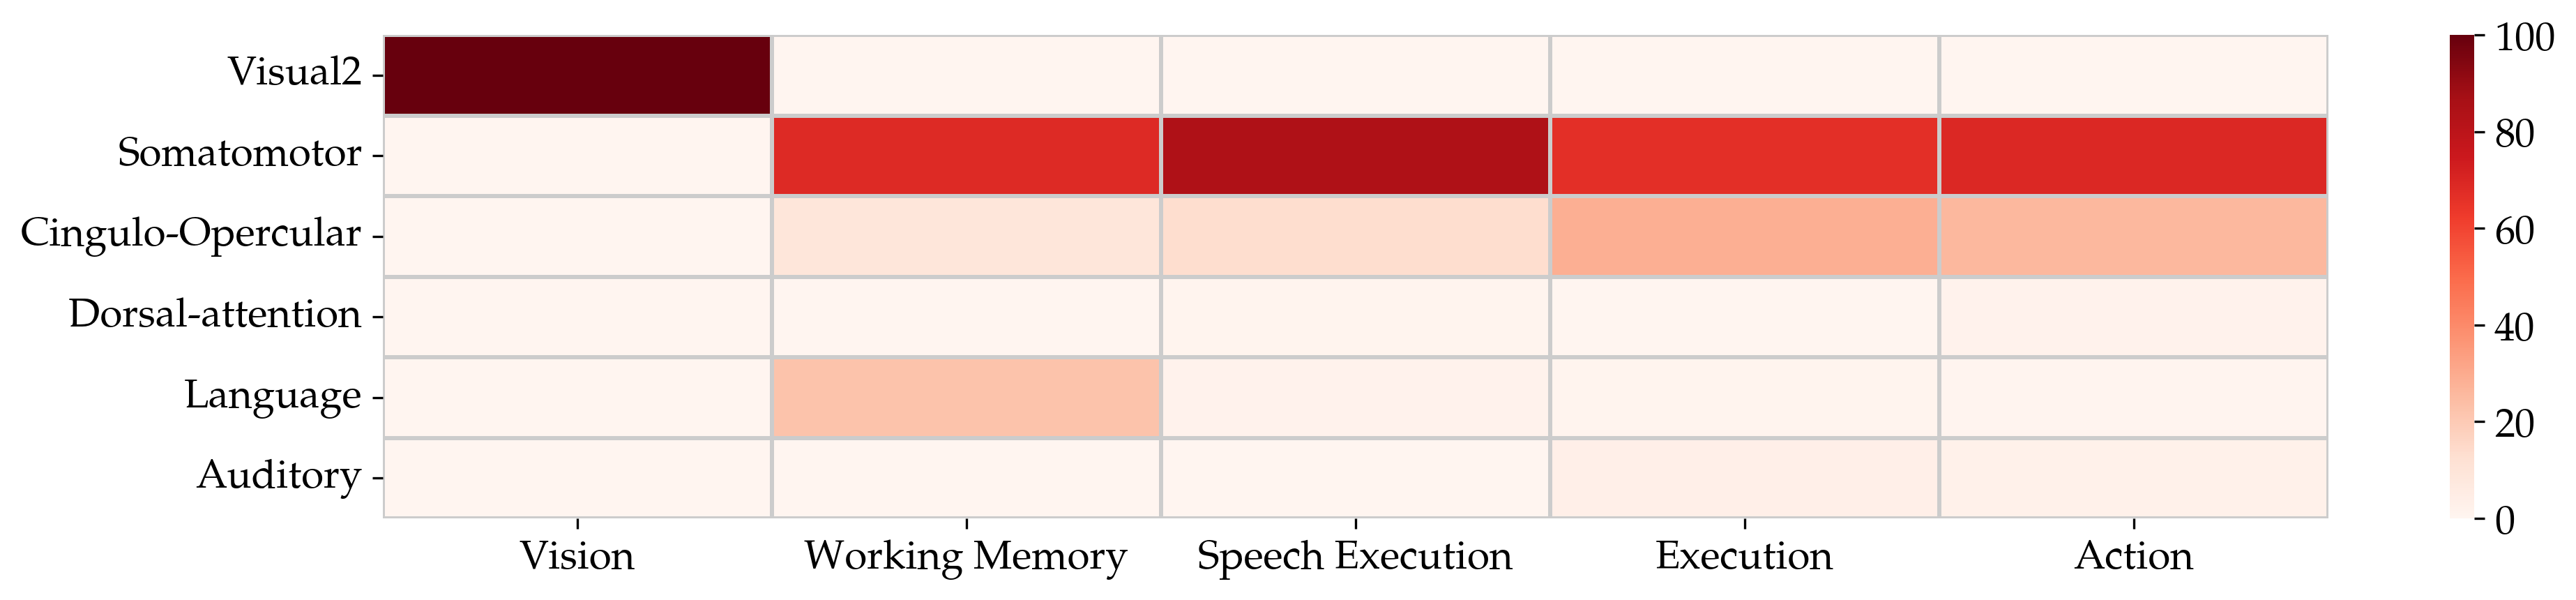

In [24]:
# Perform hierarchical clustering and plot dendrogram
fig, ax = plt.subplots(figsize=(10, 2))
model, dendro, leaf_order = utils.hierarchical_clustering(ca_pct.T, no_plot=False, ax=ax)
ax.set_ylim([-25, ax.get_ylim()[1]])
ax.axis('off')

# Save the dendrogram to file
plt.savefig(os.path.join(supplementary_dir, 'S16c_Ji2019_percentage_dendrogram.png'), bbox_inches='tight', dpi=300)

# reorder the original data
ca_pct_reordered = ca_pct.iloc[:, leaf_order]

# plot the reordered data
fig, ax = plt.subplots(figsize=(15, 3))
sns.heatmap(ca_pct_reordered, cmap='Reds', linewidths=1, linecolor='.8', ax=ax)
ax.set_xticklabels(subdomain_labels.loc[ca_pct_reordered.columns], rotation=0, horizontalalignment='center')
ax.set_yticks(np.arange(6)+0.5)
ca_labels_filtered = [ca_labels[i] for i in [1, 2, 3, 4, 5, 7]]
ax.set_yticklabels(ca_labels_filtered, rotation=0)
ax.set_ylabel('')

# Save the heatmap
plt.savefig(os.path.join(supplementary_dir, 'S16c_Ji2019_percentage_heatmap.png'), bbox_inches='tight', dpi=300)

## S16b. Calculate number of significant vertices for each MACM analysis within each cortical type (García-Cabezas et al. 2023)

Import the cortical type maps from author Amin Saberi's previous project on laminar organisation.

In [25]:
!wget -O {os.path.join(INPUT_DIR, 'maps/lh_economo.annot')} https://github.com/amnsbr/laminar_organization/raw/master/src/lh_economo.annot
!wget -O {os.path.join(INPUT_DIR, 'maps/rh_economo.annot')} https://github.com/amnsbr/laminar_organization/raw/master/src/rh_economo.annot
!wget -O {os.path.join(INPUT_DIR, 'maps/economo_cortical_types.csv')} https://github.com/amnsbr/laminar_organization/raw/master/src/economo_cortical_types.csv

--2024-10-31 22:14:26--  https://github.com/amnsbr/laminar_organization/raw/master/src/lh_economo.annot
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/amnsbr/laminar_organization/master/src/lh_economo.annot [following]
--2024-10-31 22:14:26--  https://raw.githubusercontent.com/amnsbr/laminar_organization/master/src/lh_economo.annot
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1312039 (1.3M) [application/octet-stream]
Saving to: ‘/data/project/cerebellum_ale/public/input/maps/lh_economo.annot’

/data/project/cereb 100%[===================>]   1.25M  --.-KB/s    in 0.06s   

2024-10-31 22:14:2

Load labeled Economo map in fsaverage

In [24]:
lh_parc_indices, _ , labels = nibabel.freesurfer.io.read_annot(os.path.join(INPUT_DIR, 'maps/lh_economo.annot'))
labels = [s.decode('utf-8') for s in labels]
lh_parc = np.vectorize(dict(enumerate(labels)).get)(lh_parc_indices)
rh_parc_indices, _ , labels = nibabel.freesurfer.io.read_annot(os.path.join(INPUT_DIR, 'maps/rh_economo.annot'))
labels = [s.decode('utf-8') for s in labels]
rh_parc = np.vectorize(dict(enumerate(labels)).get)(rh_parc_indices)
economo_fsa = np.concatenate([lh_parc, rh_parc])
economo_fsa

array(['FA', 'PE', 'FB', ..., 'TE', 'TE', 'TE'], dtype='<U7')

Map parcels to cortical types

In [25]:
economo_ctypes = pd.read_csv(os.path.join(INPUT_DIR, 'maps/economo_cortical_types.csv'), index_col=0)
ctypes_fsa = (
    economo_ctypes.loc[economo_fsa]
    .reset_index(drop=True)
    .iloc[:, 0].astype('category')
    .cat.reorder_categories(['ALO', 'AG', 'DG', 'EU1', 'EU2', 'EU3', 'KO'])
)
ctypes_fsa.shape

(327684,)

Transform ctypes map to fsLR and save it as Gifti:

In [26]:
lh_tf = tempfile.mktemp('.shape.gii')
lh_ctypes_fsa_gii = neuromaps.transforms.construct_shape_gii(ctypes_fsa.cat.codes.values[:ctypes_fsa.shape[0]//2])
lh_ctypes_fsa_gii.to_filename(lh_tf)
rh_tf = tempfile.mktemp('.shape.gii')
rh_ctypes_fsa_gii = neuromaps.transforms.construct_shape_gii(ctypes_fsa.cat.codes.values[ctypes_fsa.shape[0]//2:])
rh_ctypes_fsa_gii.to_filename(rh_tf)

In [27]:
ctypes_fsLR_gii = neuromaps.transforms.fsaverage_to_fslr((lh_tf, rh_tf), method='nearest')

In [30]:
ctypes_fsLR_gii[0].to_filename(os.path.join(INPUT_DIR, 'maps/lh_ctypes_fsLR.shape.gii'))
ctypes_fsLR_gii[1].to_filename(os.path.join(INPUT_DIR, 'maps/rh_ctypes_fsLR.shape.gii'))

In [28]:
ctypes_fsLR = np.concatenate([
    ctypes_fsLR_gii[0].agg_data(),
    ctypes_fsLR_gii[1].agg_data()
])
ctypes_fsLR[ctypes_fsLR < 1] = np.NaN # is set to -1 by codes
ctypes_fsLR.shape

(64984,)

### S16b. Plot the cortical types parcellation

In [32]:
meshes_ct = {
    'L': str(neuromaps.datasets.fetch_fslr()['midthickness'][0]),
    'R': str(neuromaps.datasets.fetch_fslr()['midthickness'][1])
}
utils.plot_surface(ctypes_fsLR, meshes_ct, cmap='Spectral', filename=os.path.join(supplementary_dir, 'S16b_cortical_types-parcellation'))

'/data/project/cerebellum_ale/public/output/figures/Figure6/Supplementary/S16b_cortical_types-parcellation.png'

In [33]:
# Define label mapping
label_mapping = {
    'ALO': 'Alocortex',
    'AG': 'Agranular',
    'DG': 'Dysgranular',
    'EU1': 'Eulaminate I',
    'EU2': 'Eulaminate II',
    'EU3': 'Eulaminate III',
    'KO': 'Koniocortex'
}

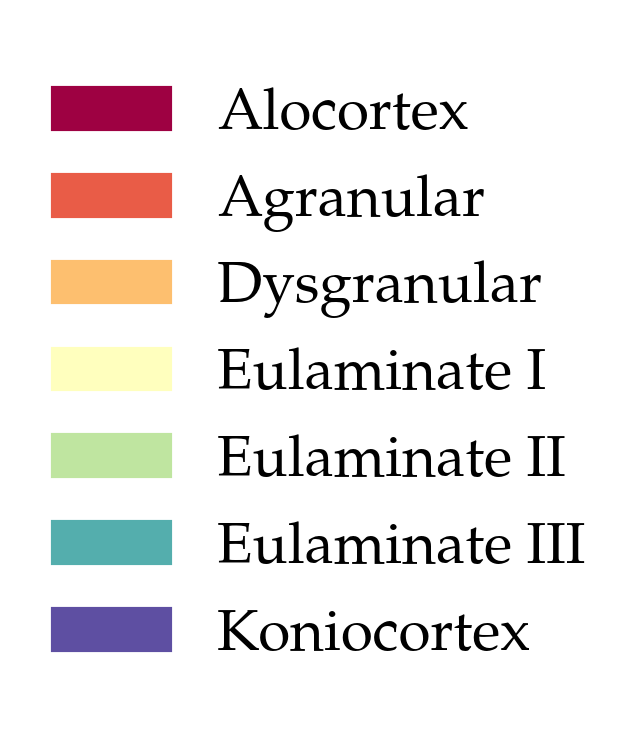

In [34]:
# Extract unique labels and corresponding colors
labels = ctypes_fsa.cat.categories
cmap = plt.get_cmap('Spectral')
colors = [cmap(i / (len(labels) - 1)) for i in range(len(labels))]

# Create legend handles
handles = [mpatches.Patch(color=colors[i], label=label_mapping[labels[i]]) for i in range(len(labels))]

# Create a new figure for the legend
fig = plt.figure(figsize=(2,3))
ax = fig.add_subplot(111)  # Add a subplot to the figure
ax.axis('off')  # Hide the axis

# Add the legend to the figure
fig.legend(handles=handles, loc='center', frameon=False)

# Save the figure to a file
fig.savefig(os.path.join(supplementary_dir, 'S16b_cortical_types-Legend.png'), bbox_inches='tight')

# Show the legend (optional)
plt.show()

### Calculate percentage of cortical types in each thresholded MACM map

In [43]:
counts = {}

for macm_path in tqdm(sorted(glob.glob(
    os.path.join(OUTPUT_DIR,'SALE/*/*/corr_cluster_h-001_k-50_mask-D2009_MNI_z_macm/corr_cluster_k-50_z.nii.gz')
))):
    # Use regular expression to extract the subdomain (subbd) from the path
    match = re.search(r'SALE/[^/]+/([^/]+)/corr_cluster_h-001_k-50_mask-D2009_MNI_z_macm/corr_cluster_k-50_z\.nii\.gz$', macm_path)
    if match:
        subbd = match.group(1)  # Extracted subdomain name
        # Check if subbd is in filtered_domains or filtered_subdomains
        if subbd not in filtered_domains and subbd not in filtered_subdomains:
            print(f"{subbd} not in filtered_domains or filtered_subdomains, skipping.")
            continue  # Skip to the next iteration if subbd is not in either list
    # binarize
    macm_bin = nilearn.image.binarize_img(macm_path)
    # transform to fsLR
    tfile = tempfile.mktemp('.nii.gz')
    macm_bin.to_filename(tfile)
    macm_fslr_gii = neuromaps.transforms.mni152_to_fslr(tfile, method='nearest')
    macm_fslr = np.concatenate([
        macm_fslr_gii[0].agg_data().flatten(),
        macm_fslr_gii[1].agg_data().flatten()
    ])
    # check if there are any significant cortical MACM regions
    if macm_fslr.sum() == 0:
        print(subbd, "has no significant cortical MACM vertices")
        continue
    counts[subbd] = pd.DataFrame({
        'macm': macm_fslr.astype(bool),
        'ct': ctypes_fsLR
    }).groupby('macm')['ct'].value_counts(sort=False, dropna=False)[(True, slice(None))]

counts = pd.DataFrame(counts).fillna(0)
# add 0s for missing types
counts = pd.concat([counts, pd.Series(np.NaN, index=range(1,7))],axis=1).sort_index().iloc[:, :-1].fillna(0)
# calculate percentages
ct_pct = (counts / counts.values.sum(axis=0, keepdims=True)) * 100

 17%|██████████████▊                                                                          | 2/12 [00:01<00:06,  1.48it/s]

Action.Observation not in filtered_domains or filtered_subdomains, skipping.


 33%|█████████████████████████████▋                                                           | 4/12 [00:02<00:03,  2.15it/s]

Cognition.Language not in filtered_domains or filtered_subdomains, skipping.


 50%|████████████████████████████████████████████▌                                            | 6/12 [00:02<00:02,  2.47it/s]

Cognition.SocialCognition not in filtered_domains or filtered_subdomains, skipping.
Emotion.Negative.Sadness not in filtered_domains or filtered_subdomains, skipping.
Perception.Somesthesis not in filtered_domains or filtered_subdomains, skipping.
Perception.Vision.Motion not in filtered_domains or filtered_subdomains, skipping.
Perception.Vision.Shape not in filtered_domains or filtered_subdomains, skipping.


100%|████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.57it/s]


In [35]:
ct_labels = list(ctypes_fsa.cat.categories)[1:7]
ct_labels
ctype_labels = pd.Series({
    'AG': 'Agranular',
    'DG': 'Dysgranular',
    'EU1': 'Eulaminate I',
    'EU2': 'Eulaminate II',
    'EU3': 'Eulaminate III',
    'KO': 'Koniocortex'
})

### S16b. MACM correspondence to cortical types.

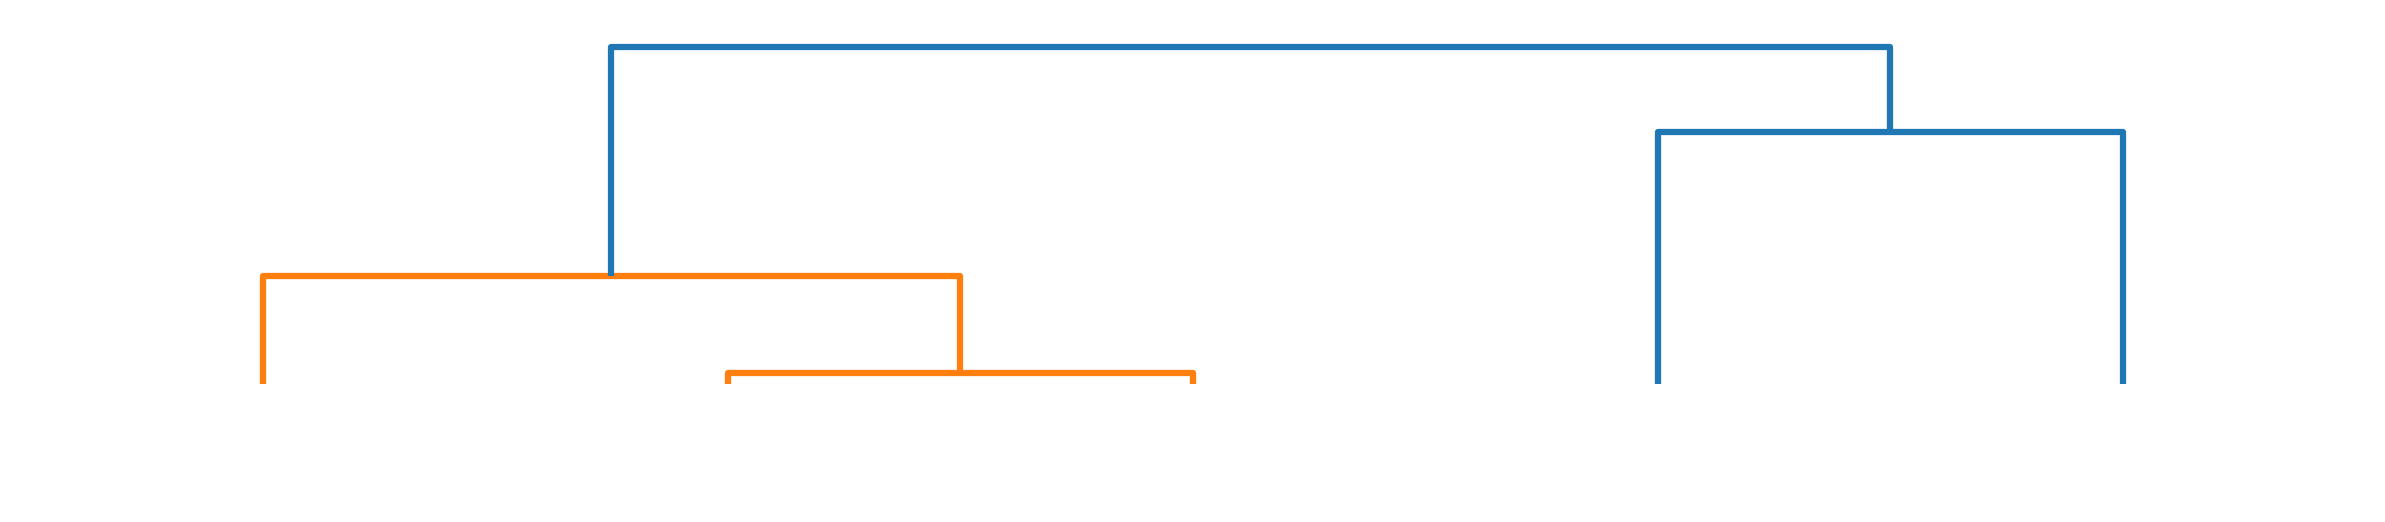

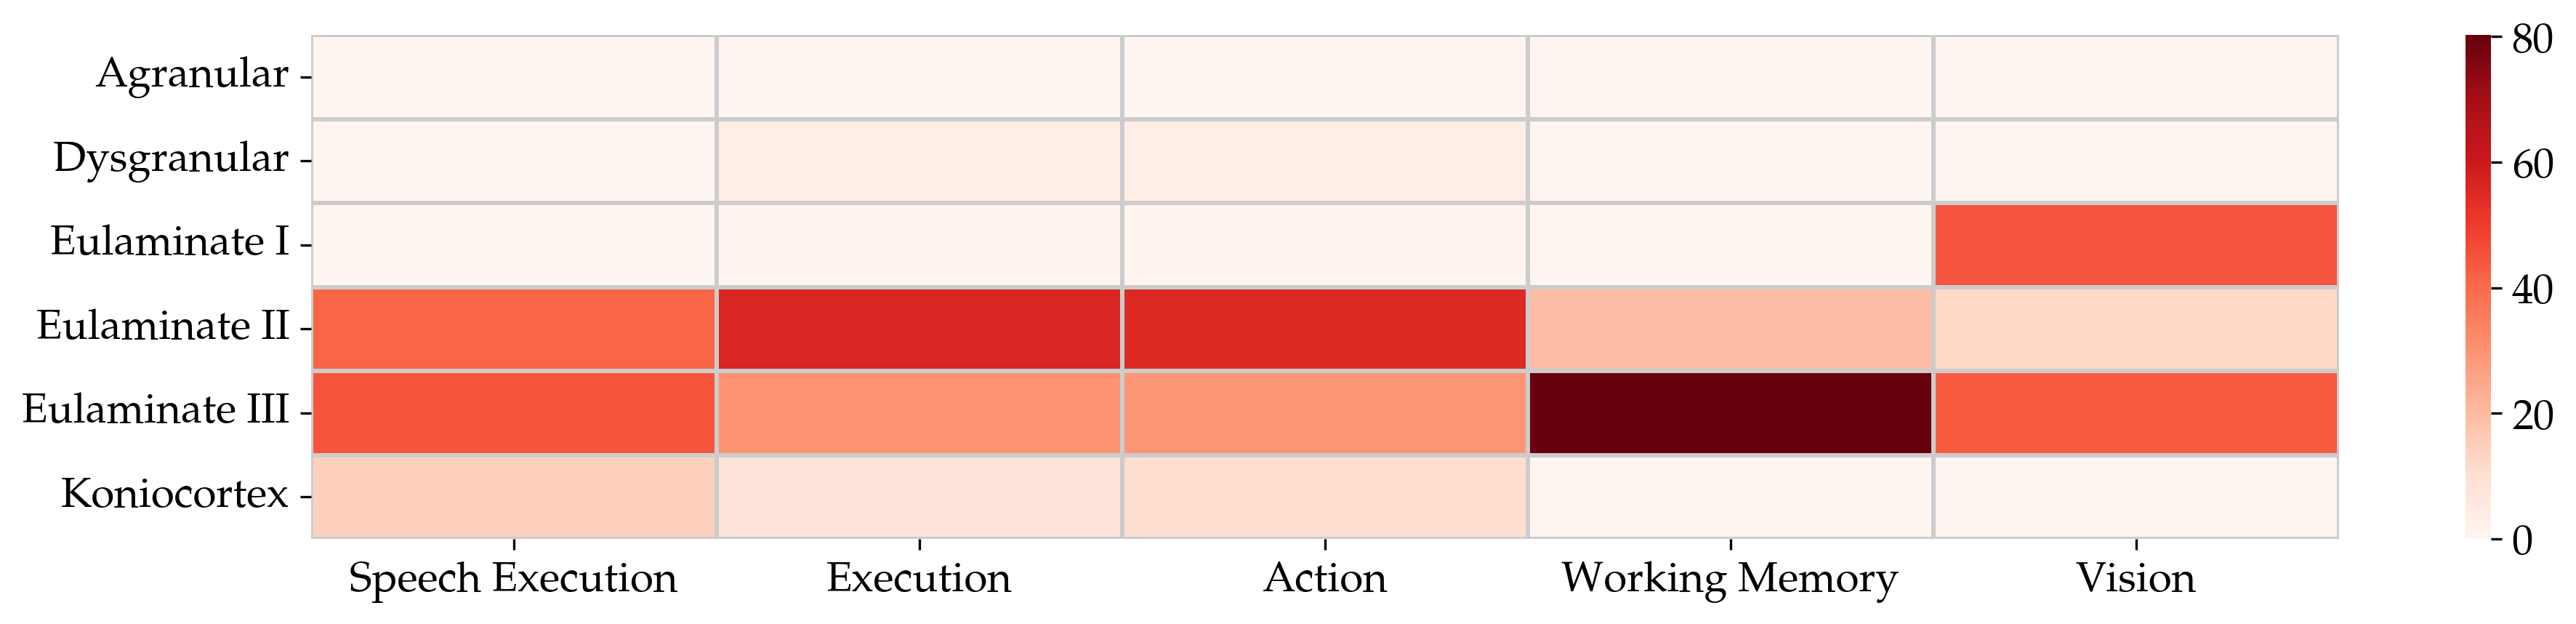

In [43]:
# Perform hierarchical clustering and plot dendrogram
fig, ax = plt.subplots(figsize=(10, 2))
model, dendro, leaf_order = utils.hierarchical_clustering(ct_pct.T, no_plot=False, ax=ax)
ax.set_ylim([-25, ax.get_ylim()[1]])
ax.axis('off')

# Save the dendrogram to file
plt.savefig(os.path.join(supplementary_dir, 'S16b_Garcia-Cabezas2023_percentage_dendrogram.png'), bbox_inches='tight', dpi=300)

# extract the ordering
leaf_order = dendro['leaves']
# reorder the original data
ct_pct_reordered = ct_pct.iloc[:, leaf_order]

# plot the reordered data
fig, ax = plt.subplots(figsize=(15, 3))
sns.heatmap(ct_pct_reordered, cmap='Reds', linewidths=1, linecolor='.8', ax=ax)
ax.set_xticklabels(subdomain_labels.loc[ct_pct_reordered.columns], rotation=0, horizontalalignment='center')
ax.set_yticks(np.arange(6)+0.5)
ax.set_yticklabels(ctype_labels, rotation=0)
ax.set_ylabel('')
# Save the dendrogram to file
plt.savefig(os.path.join(supplementary_dir, 'S16b_Garcia-Cabezas2023_percentage_heatmap.png'), bbox_inches='tight', dpi=300)

## 6b,d. MACM maps across the subcortex

Resample it to the mask of the MACM data (2mm MNI)

In [44]:
tian = nibabel.load(os.path.join(INPUT_DIR,'maps/Tian_Subcortex_S1_3T.nii'))
mask = nibabel.load(os.path.join(INPUT_DIR, 'maps/Grey10.nii.gz'))
tian_2mm = nilearn.image.resample_to_img(tian, mask)
# nilearn.plotting.plot_stat_map(tian_2mm)

### S16a. Calculate number of significant voxels for each MACM analysis within each Tian parcel

In [45]:
counts = {}

# Iterate over each file path that matches the pattern
for macm_path in tqdm(sorted(glob.glob(
    '/data/project/cerebellum_ale/output/SALE/*/*/corr_cluster_h-001_k-50_mask-D2009_MNI_z_macm/corr_cluster_k-50_z.nii.gz'
))):
    # Use regular expression to extract the subbd value
    match = re.search(r'/SALE/[^/]+/([^/]+)/corr_cluster_h-001_k-50_mask-D2009_MNI_z_macm/corr_cluster_k-50_z\.nii\.gz$', macm_path)
    if match:
        subbd = match.group(1)
    else:
        print(f"Pattern not found in path: {macm_path}")
        continue  # Skip this path if the subbd pattern is not found

    # Binarize the NIfTI image
    macm_bin = nilearn.image.binarize_img(macm_path)

    # Count the values and add to the counts dictionary
    counts[subbd] = pd.DataFrame({
        'macm': macm_bin.get_fdata().flatten(),
        'tian': tian_2mm.get_fdata().flatten() 
    }).groupby('macm')['tian'].value_counts(sort=False)[(1, slice(None))]

# Convert counts to a DataFrame and sort the index
counts = pd.DataFrame(counts).sort_index()

# Define the list of valid subdomains
valid_MACMs = filtered_domains + filtered_subdomains

# Filter the counts DataFrame to only keep the columns in the valid subdomains list
counts = counts.loc[:, counts.columns.intersection(valid_MACMs)]
# drop empty/nan counts
counts_sctx = counts.drop(index=0.0).fillna(0)
pct = (counts_sctx / counts_sctx.values.sum(axis=0, keepdims=True)) * 100
pct = pct.dropna(axis=1)

# create full counts for these (subd)domains
pct_full = (
    pd.concat([
        pct,
        pd.Series(np.arange(1, 17)).rename('index')
    ], axis=1)
    .set_index('index')
    .sort_index()
    .fillna(0)
)
pct_full

100%|█████████████████████████████████████████████████████████████████████████████████| 12/12 [00:08<00:00,  1.44it/s]


Action.Execution.Speech  Action.Execution     Action
index                                                      
1                     0.000000          0.000000   0.000000
2                     0.000000          0.000000   0.000000
3                     0.000000          0.000000   0.000000
4                     0.000000          4.297994   3.857567
5                     0.000000         12.607450   9.792285
6                     0.000000          0.000000   0.000000
7                     1.831502          0.286533   0.148368
8                    29.670330          8.739255   9.643917
9                     0.000000          0.000000   0.000000
10                    0.000000          0.000000   0.000000
11                    0.000000          0.000000   0.000000
12                   20.512821         25.358166  26.261128
13                   23.809524         17.765043  19.287834
14                    0.000000          0.000000   0.000000
15                    4.029304          0.429799   0.148368
16                   20.146520         30.515759  30.860534

Note that 0 are all the voxels outside (!) of the resampled Tian et al. (2020) mask. In essence, primarily cerebral and cerebellar voxels.

9 rows (Tian Parcels + background) x 5 colums (Valid MACM analyses)..
Drop anything non-subcortical (0.0) and calculate percentages.

In [46]:
# Load Tian et al. (2020) subcortical labels
labels = np.loadtxt(os.path.join(INPUT_DIR,
    'maps/Tian_Subcortex_S1_3T_label.txt'),
    dtype=str
)
labels_clean = [
    f'{h} {struct}' for h, struct in \
    itertools.product(
        ['R', 'L'],
        ['Hippocampus',
         'Amygdala',
         'Posterior Thalamus',
         'Anterior Thalamus',
         'Nucleus Accumbens',
         'Globus Pallidum',
         'Putamen',
         'Caudate']
    )
]
labels_clean

['R Hippocampus',
 'R Amygdala',
 'R Posterior Thalamus',
 'R Anterior Thalamus',
 'R Nucleus Accumbens',
 'R Globus Pallidum',
 'R Putamen',
 'R Caudate',
 'L Hippocampus',
 'L Amygdala',
 'L Posterior Thalamus',
 'L Anterior Thalamus',
 'L Nucleus Accumbens',
 'L Globus Pallidum',
 'L Putamen',
 'L Caudate']

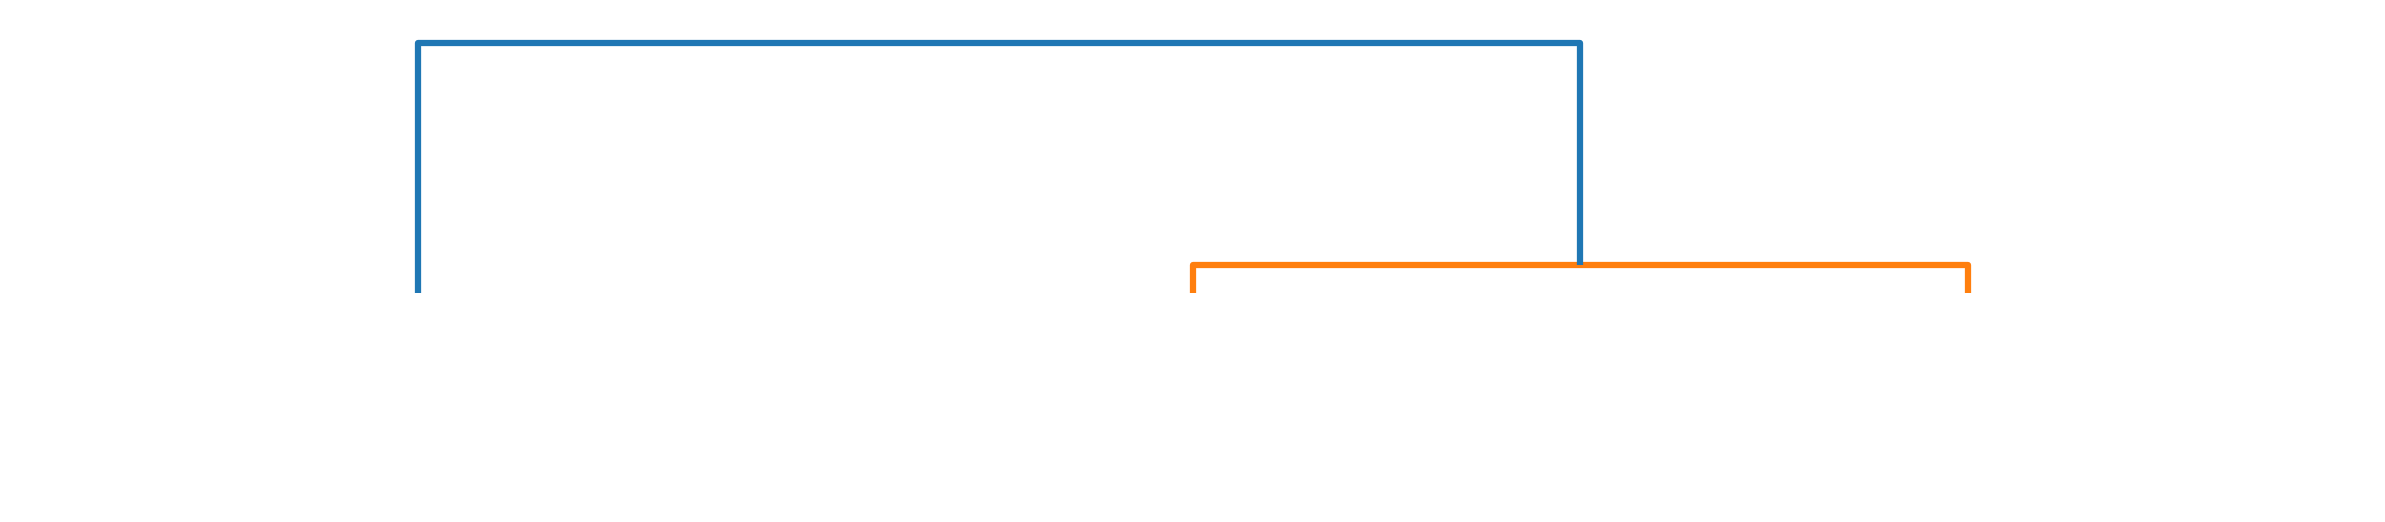

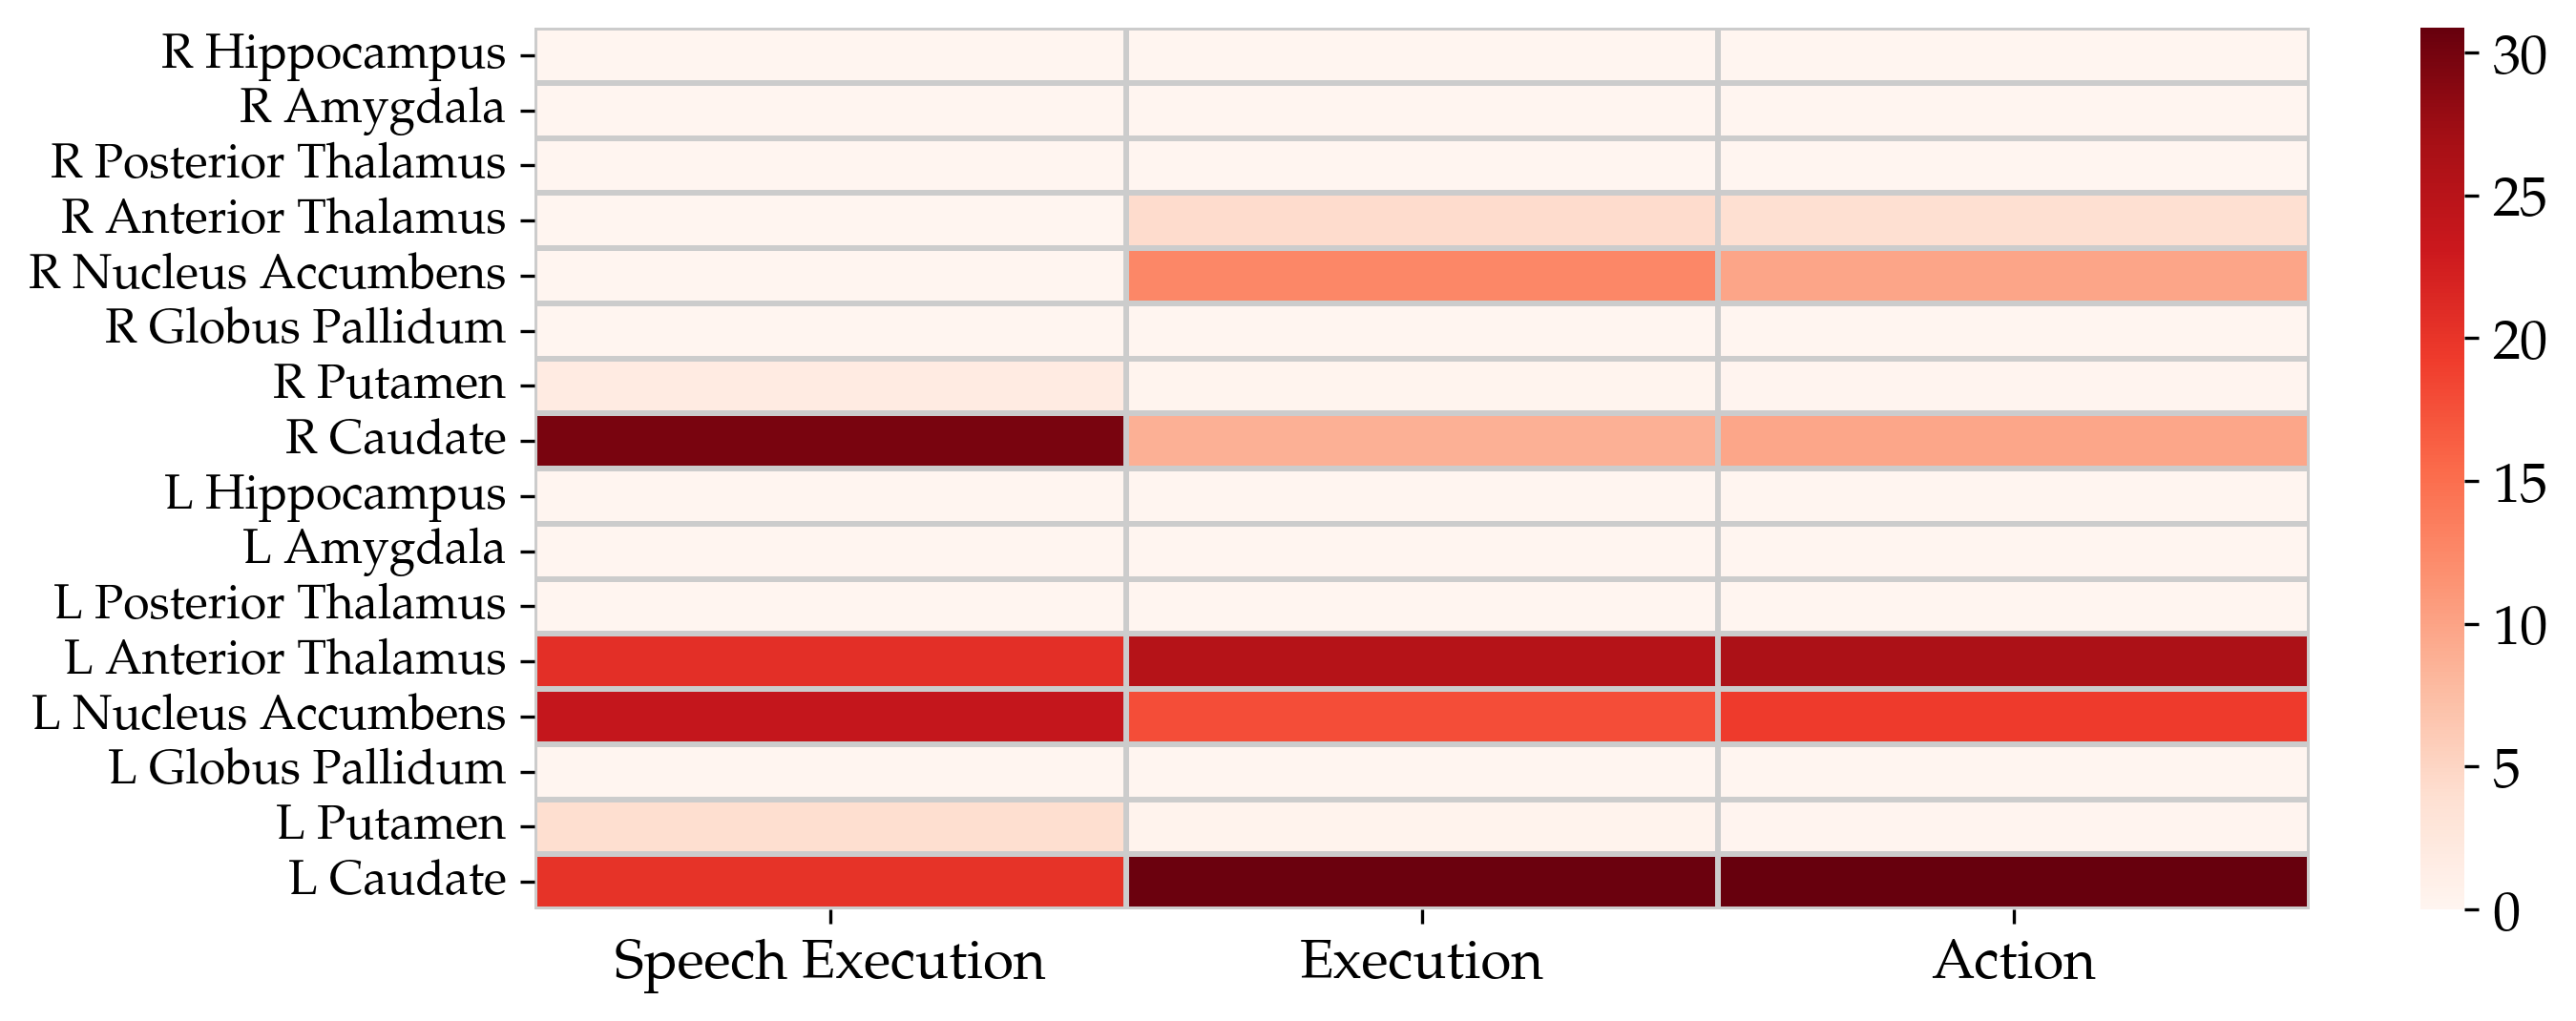

In [47]:
# Perform hierarchical clustering and plot dendrogram
fig, ax = plt.subplots(figsize=(10, 2))
model, dendro, leaf_order = utils.hierarchical_clustering(pct.T, no_plot=False, ax=ax)
ax.set_ylim([-25, ax.get_ylim()[1]])
ax.axis('off')

# Save the dendrogram to file
plt.savefig(os.path.join(supplementary_dir, 'S16a_Tian2022_percentage_dendrogram.png'), bbox_inches='tight', dpi=300)

# Create the correlation heatmap.
# reorder the original data
pct_reordered = pct_full.iloc[:, leaf_order]

# plot the reordered data
fig, ax = plt.subplots(figsize=(10, 4))
sns.heatmap(pct_reordered, cmap='Reds', linewidths=1, linecolor='.8', ax=ax)
ax.set_xticklabels(subdomain_labels.loc[pct_reordered.columns], rotation=0, horizontalalignment='center')
ax.set_yticks(np.arange(len(labels_clean))+0.5)
ax.set_yticklabels(labels_clean, rotation=0, fontsize=12)
ax.set_ylabel('')

# Save the heatmap
plt.savefig(os.path.join(supplementary_dir, 'S16a_Tian2022_percentage_heatmap.png'), bbox_inches='tight', dpi=300)

### Plot MACM maps across subcortex

In [48]:
# Loop over all MACM maps
for macm_path in tqdm(sorted(glob.glob(
    os.path.join(OUTPUT_DIR, 'SALE/*/*/corr_cluster_h-001_k-50_mask-D2009_MNI_z_macm/corr_cluster_k-50_z.nii.gz'
)))):
    # Use regular expression to extract the second subdirectory after SALE
    match = re.search(r'SALE/[^/]+/([^/]+)/corr_cluster_h-001_k-50_mask-D2009_MNI_z_macm/corr_cluster_k-50_z\.nii\.gz$', macm_path)
    if match:
        subbd = match.group(1)  # Extracted subdomain name
    else:
        print(f"Pattern not matched for path: {macm_path}")
        continue  # Skip to the next iteration if no match is found

    # Load the MACM map
    macm_img = nilearn.image.load_img(macm_path)

    # Binarize the MACM map
    macm_bin = nilearn.image.binarize_img(macm_img)

    # Apply the subcortex mask to the binarized MACM map
    macm_bin_crop = nilearn.image.math_img('img1 * img2', img1=macm_bin, img2=tian_2mm)

    # Convert the cropped MACM map to a numpy array and check if there's any data
    macm_bin_crop_data = macm_bin_crop.get_fdata()
    if np.any(macm_bin_crop_data):  # Only plot if there's any data in the cropped MACM map

        # Get the nicer label for the current subdomain
        label = subdomain_labels.get(subbd, subbd) 

        # Define the directory where the figure will be saved, adding the subbd as a subfolder
        save_dir = os.path.join(supplementary_dir, 'Subcortex', subbd)
        os.makedirs(save_dir, exist_ok=True) 

        # Create a new figure
        fig, ax = plt.subplots(figsize=(20, 4))

        nilearn.plotting.plot_stat_map(
            macm_bin_crop, 
            cmap='Reds', 
            display_mode='z', 
            cut_coords=[-6, -2, 2, 6], 
            title=None,
            axes=ax,
            colorbar=False
        )

        # Set the title using Matplotlib to avoid the black box background
        ax.set_title(f"{label}", size=20, backgroundcolor='none', loc='right', y=1.05, fontweight='bold')

        # Define the file path for saving with the prefix
        fig_path = os.path.join(save_dir, f'{subbd}_macm_thres_tian2020.png')
        plt.savefig(fig_path)
        plt.close(fig)


100%|█████████████████████████████████████████████████████████████████████████████████| 12/12 [00:27<00:00,  2.29s/it]


## 6a. Subcortical parcellation (Tian et al. (2020).

Label Look-up table: https://github.com/yetianmed/subcortex/blob/master/Group-Parcellation/3T/Subcortex-Only/Nomenclature-subcortex-parcellation-hierarchy-3T.pdf

In [49]:
# Load your nifti image
tian_data = tian_2mm.get_fdata()

# Prevent potential compatibility issues with int64
labeled_data = np.zeros(tian_data.shape, dtype=np.int32)

for i, label in enumerate(labels, start=1):
    # Assign a unique integer to each label
    labeled_data[tian_data == i] = i

# Add the labels to the nifti images
labeled_img = nibabel.Nifti1Image(labeled_data, tian_2mm.affine)

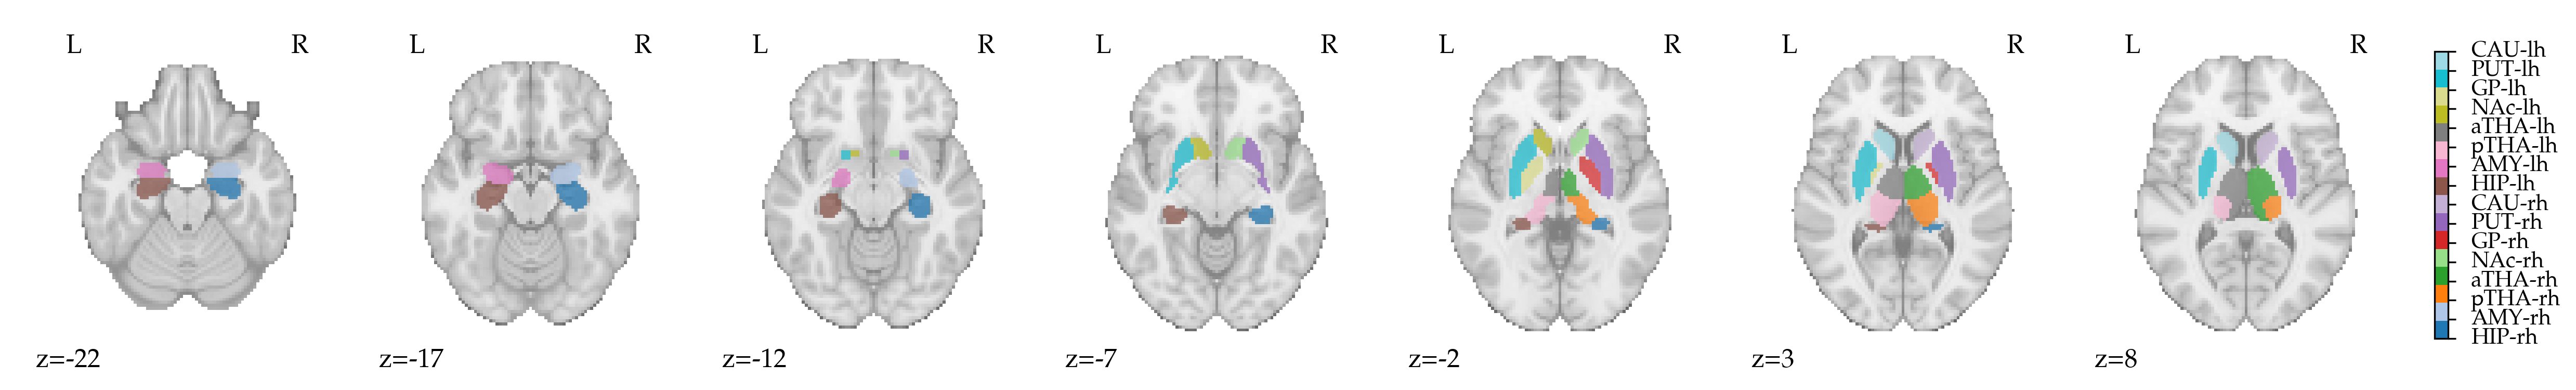

In [50]:
# Colormap
cmap = plt.cm.get_cmap('tab20', len(labels))

# Plotting (the labeled image from the previous)
display = plot_roi(
    labeled_img,
    display_mode='z', 
    colorbar=False,  # Disable default colorbar
    cut_coords=[-22, -17, -12, -7, -2, 3, 8],
    cmap=cmap  
)

# Colorbar from matplotlib itself
fig = display.frame_axes.figure
cax = fig.add_axes([1.0, 0.1, 0.02, 0.8]) # Set the position of the colorbar

# Create the colorbar
norm = plt.Normalize(vmin=1, vmax=len(labels))
cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax)

# Add colorbar ticks and labels
cbar.set_ticks(np.arange(1, len(labels) + 1))
cbar.set_ticklabels(labels)

# Font size and position of labels
for label in cbar.ax.get_yticklabels():
    label.set_fontsize(10)
    label.set_verticalalignment('center')  # Align labels centrally.

# Adjust the spacing
cbar.ax.tick_params(pad=7)  # Distance between ticks and labels.

# Stretch out the colorbar
cax.set_aspect(1.4)  # Aspect ratio for the colorbar. Some stretch was needed.

# Save the plot
fig.savefig(os.path.join(figure_dir, '6a_Tian_connectivity-gradient_parcellation-legend.png'), dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

## MACM maps across the cerebellum

### Load the C-SALE maps

Load valid domains (in MACM)

In [52]:
# Initialize dictionaries to store results 
surf_zmaps_thr = {}
surf_cluster_boundary_coords = {}
for analysis in ['SALE']:
    surf_zmaps_thr[analysis] = {}
    surf_cluster_boundary_coords[analysis] = {}
    for domain in filtered_domains:
        print(analysis, domain)
        try:
            results = utils.load_results(analysis, domain)
        except FileNotFoundError:
            print(f"(Un)corrected {analysis} results not found for {domain}")
            continue
        surf_zmaps_thr[analysis][domain] = results[analysis][domain]['corr']
        surf_cluster_mask = (surf_zmaps_thr[analysis][domain] > 0).astype(int)
        surf_cluster_boundary_coords[analysis][domain] = utils.get_flatmap_mask_boundary_coords(surf_cluster_mask)

SALE Action


Load valid subdomains (in MACM)

In [53]:
subbd_surf_zmaps_thr = {}
subbd_surf_cluster_boundary_coords = {}
for analysis in ['SALE']:
    subbd_surf_zmaps_thr[analysis] = {}
    subbd_surf_cluster_boundary_coords[analysis] = {}
    for subdomain in filtered_subdomains:
        # Split into domain and subdomain (e.g., "Action.Execution")
        domain, subdomain_name = subdomain.split('.', 1)
        print(f"Loading {analysis} results for {subdomain}")
        try:
            results = utils.load_results(analysis, domain, subdomain=subdomain_name)
        except FileNotFoundError:
            print(f"(Un)corrected {analysis} results not found for {subdomain}")
            continue
        subbd_surf_zmaps_thr[analysis][subdomain] = results[analysis][subdomain]['corr']
        subbd_surf_cluster_mask = (subbd_surf_zmaps_thr[analysis][subdomain] > 0).astype(int)
        subbd_surf_cluster_boundary_coords[analysis][subdomain] = utils.get_flatmap_mask_boundary_coords(subbd_surf_cluster_mask)

Loading SALE results for Action.Execution
Loading SALE results for Action.Execution.Speech
Loading SALE results for Cognition.Memory.Working
Loading SALE results for Perception.Vision


### Plot MACM maps across the cerebellum including outlines of C-SALE seeds

Stats = 'SPM' and space = currently 'nanmean', but can be set to 'mode' if a more conservative plot is desired.
see https://suitpy.readthedocs.io/en/latest/reference.html,  Diedrichsen et al. (2015) https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0133402
and https://github.com/DiedrichsenLab/SUITPy/blob/79ba5656fa284d226357108b95d81c996275e10e/SUITPy/flatmap.py#L33 for details. 

#### Domains

In [54]:
# Create a custom red colormap
rgb_color = (170/255, 0/255, 34/255)  # RGB values for darker burgundy

# Create two identical colors (using the RGB tuple)
colors = [rgb_color, rgb_color]

# Create the custom colormap
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)

In [55]:
for domain in filtered_domains:
    # Construct file path for the current domain
    macm_nifti = os.path.join(OUTPUT_DIR, f'SALE/{domain}/{domain}/corr_cluster_h-001_k-50_mask-D2009_MNI_z_macm/corr_cluster_k-50_z.nii.gz')

    # Check if the file path exists
    if os.path.exists(macm_nifti):
        macm_bin = nilearn.image.binarize_img(macm_nifti) # Binarization
        # Create a new figure and plot the surface data
       
        # Get the current axis of the plot
        ax = plt.gca()

        # Create a new figure and plot the surface data
        surface_map = SUITPy.flatmap.vol_to_surf(macm_bin, space = 'SPM').squeeze(), 

        surface_data = surface_map[0]  # Get the surface map data
        binarized_surface_data = np.where(surface_data > 0, 1, 0) # We need to binarize again, since stats = 'nanmean' (default) averages across 6 GM depths and thus efectively removes binarization in our maps.
            
        # Plot the flatmap for the current subdomain
        SUITPy.flatmap.plot(binarized_surface_data, colorbar=False, cmap=custom_cmap, underscale = [-0.3, 1],  new_figure=False)
 
        # Overlay the cluster borders on top
        ax.plot(surf_cluster_boundary_coords['SALE'][domain][:, 0], surf_cluster_boundary_coords['SALE'][domain][:, 1], # Enable borders if desired.
               color='black', marker='.', linestyle=None, markersize=0.01, linewidth=0)
        
        # Set the title for the plot
        ax.set_title(domain, fontsize=24)
        
        # Define the directory path for saving the figure
        save_dir_domain = os.path.join(figure_dir)
        os.makedirs(save_dir_domain, exist_ok=True)  # Create the directory if it does not exist.
        
        # Define the file name for saving the figure
        save_filename = f"6b_{domain}_MACM_Cerebellum-Surface_p001_K50_wborders.png"
        
        # Define the full path to save the figure
        save_path = os.path.join(save_dir_domain, save_filename)
        
        # Save the figure to the specified path
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
        
        plt.close()
        
    else:
        print(f"File path does not exist for domain: {domain}. Skipping...")

##### MACM seeds

Color them blue for visual distinction

In [56]:
for domain in filtered_domains:
    # Construct file path for the current domain
    sale_nifti = os.path.join(OUTPUT_DIR, f'SALE/{domain}/{domain}/corr_cluster_h-001_k-50_mask-D2009_MNI_z.nii.gz')

    # Check if the file path exists
    if os.path.exists(macm_nifti):
        sale_bin = nilearn.image.binarize_img(sale_nifti) # Binarization
        # Create a new figure and plot the surface data
       
        # Get the current axis of the plot
        ax = plt.gca()

        # Create a new figure and plot the surface data
        surface_map = SUITPy.flatmap.vol_to_surf(sale_bin, space = 'SPM').squeeze(), 

        surface_data = surface_map[0]  # Get the surface map data
        binarized_surface_data = np.where(surface_data > 0, 1, 0) # We need to binarize again, since stats = 'nanmean' (default) averages across 6 GM depths and thus efectively removes binarization in our maps.
            
        # Plot the flatmap for the current subdomain
        SUITPy.flatmap.plot(binarized_surface_data, colorbar=False, cmap='Paired', underscale = [-0.3, 1],  new_figure=False)
 
        # # Overlay the cluster borders on top
        # ax.plot(surf_cluster_boundary_coords['SALE'][domain][:, 0], surf_cluster_boundary_coords['SALE'][domain][:, 1], # Enable borders if desired.
        #        color='black', marker='.', linestyle=None, markersize=0.01, linewidth=0)
        
        # Set the title for the plot
        ax.set_title(domain, fontsize=24)
        
        # Define the directory path for saving the figure
        save_dir_domain = os.path.join(supplementary_dir)
        os.makedirs(save_dir_domain, exist_ok=True)  # Create the directory if it does not exist.
        
        # Define the file name for saving the figure
        save_filename = f"S15a_{domain}_MACM_Cerebellum-Surface_p001_K50_seeds.png"
        
        # Define the full path to save the figure
        save_path = os.path.join(save_dir_domain, save_filename)
        
        # Save the figure to the specified path
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
        
        plt.close()
        
    else:
        print(f"File path does not exist for domain: {domain}. Skipping...")

#### Subdomains

In [57]:
# Order the filtered subdomains directly the stats file
subdomain_order = stats.loc[filtered_subdomains, 'n_exp'].sort_values().index

##### MACM Results + borders of the seeds

In [58]:
for domain in domains:
    for subdomain in subdomain_order:
        # Construct the combined key for accessing the surf dictionary
        # combined_key = f"{domain}.{subdomain}"
        # Construct the file path for the current domain
        macm_nifti = os.path.join(OUTPUT_DIR, f'SALE/{domain}/{subdomain}/corr_cluster_h-001_k-50_mask-D2009_MNI_z_macm/corr_cluster_k-50_z.nii.gz')
        
        # Check if the file path exists
        if os.path.exists(macm_nifti):
            macm_bin = nilearn.image.binarize_img(macm_nifti)
            
            # Get the current axis (ax) associated with the plot
            ax = plt.gca()

            # Create a new figure and plot the surface data
            surface_map = SUITPy.flatmap.vol_to_surf(macm_bin, space = 'SPM').squeeze(), # Stats and space. Currently nanmean, but can be set to mode if a more conservative plot is desired.

            surface_data = surface_map[0]  # Get the surface map data (NumPy array)
            binarized_surface_data = np.where(surface_data > 0, 1, 0) # We need to binarize again, since stats = 'nanmean' (default) averages across 6 GM depths and thus efectively removes binarization in our maps.
            
            # Plot the flatmap for the current subdomain
            SUITPy.flatmap.plot(binarized_surface_data, colorbar=False, cmap=custom_cmap, underscale = [-0.3, 1],  new_figure=False)
            
            # Overlay the cluster borders on top
            ax.plot(subbd_surf_cluster_boundary_coords['SALE'][subdomain][:, 0], subbd_surf_cluster_boundary_coords['SALE'][subdomain][:, 1], # Add borders if desired.
                    color='black', marker='.', linestyle=None, markersize=0.01, linewidth=0)
            
            # Set the title for the plot
            ax.set_title(filtered_subdomain_labels[subdomain], fontsize=14)
            
            # Define the directory path for saving the figure
            save_dir_subdomain = os.path.join(supplementary_dir, 'Cerebellum', subdomain)
            os.makedirs(save_dir_subdomain, exist_ok=True)  # Create the directory if it doesn't exist
            
            # Define the file name for saving the figure
            save_filename = f"6c_{subdomain}_MACM_Cerebellum-Surface_p001_K50_wborders.png"
            
            # Define the full path to save the figure
            save_path = os.path.join(save_dir_subdomain, save_filename)
            
            # Save the figure to the specified path
            plt.savefig(save_path, bbox_inches='tight', dpi=300)
            
            plt.close()
            
        else:
            print(f"File path does not exist for subdomain: {subdomain}. Skipping...") 

File path does not exist for subdomain: Cognition.Memory.Working. Skipping...
File path does not exist for subdomain: Perception.Vision. Skipping...
File path does not exist for subdomain: Perception.Vision. Skipping...
File path does not exist for subdomain: Action.Execution.Speech. Skipping...
File path does not exist for subdomain: Action.Execution. Skipping...
File path does not exist for subdomain: Cognition.Memory.Working. Skipping...
File path does not exist for subdomain: Perception.Vision. Skipping...
File path does not exist for subdomain: Action.Execution.Speech. Skipping...
File path does not exist for subdomain: Action.Execution. Skipping...
File path does not exist for subdomain: Cognition.Memory.Working. Skipping...
File path does not exist for subdomain: Perception.Vision. Skipping...
File path does not exist for subdomain: Action.Execution.Speech. Skipping...
File path does not exist for subdomain: Action.Execution. Skipping...
File path does not exist for subdomain: C

#### Just the seeds

In [59]:
for domain in domains:
    for subdomain in subdomain_order:
        # Construct the combined key for accessing the surf dictionary
        # combined_key = f"{domain}.{subdomain}"
        # Construct the file path for the current domain
        macm_nifti = os.path.join(OUTPUT_DIR, f'SALE/{domain}/{subdomain}/corr_cluster_h-001_k-50_mask-D2009_MNI_z.nii.gz')
        
        # Check if the file path exists
        if os.path.exists(macm_nifti):
            macm_bin = nilearn.image.binarize_img(macm_nifti)
            
            # Get the current axis (ax) associated with the plot
            ax = plt.gca()

            # Create a new figure and plot the surface data
            surface_map = SUITPy.flatmap.vol_to_surf(macm_bin, space = 'SPM').squeeze(), # Stats and space. Currently nanmean, but can be set to mode if a more conservative plot is desired.

            surface_data = surface_map[0]  # Get the surface map data (NumPy array)
            binarized_surface_data = np.where(surface_data > 0, 1, 0) # We need to binarize again, since stats = 'nanmean' (default) averages across 6 GM depths and thus efectively removes binarization in our maps.
            
            # Plot the flatmap for the current subdomain
            SUITPy.flatmap.plot(binarized_surface_data, colorbar=False, cmap='Paired', underscale = [-0.3, 1],  new_figure=False)
            
            # Set the title for the plot
            ax.set_title(filtered_subdomain_labels[subdomain], fontsize=14)
            
            # Define the directory path for saving the figure
            save_dir_subdomain = os.path.join(supplementary_dir, 'Cerebellum', subdomain)
            os.makedirs(save_dir_subdomain, exist_ok=True)  # Create the directory if it doesn't exist
            
            # Define the file name for saving the figure
            save_filename = f"S15b_{subdomain}_MACM_Cerebellum-Surface_p001_K50_wborders.png"
            
            # Define the full path to save the figure
            save_path = os.path.join(save_dir_subdomain, save_filename)
            
            # Save the figure to the specified path
            plt.savefig(save_path, bbox_inches='tight', dpi=300)
            
            # Display the plot (optional)
            # display(plt.gcf())
            
            # Close the plot to release memory (optional)
            plt.close()
            
        else:
            print(f"File path does not exist for subdomain: {subdomain}. Skipping...") 

File path does not exist for subdomain: Cognition.Memory.Working. Skipping...
File path does not exist for subdomain: Perception.Vision. Skipping...
File path does not exist for subdomain: Perception.Vision. Skipping...
File path does not exist for subdomain: Action.Execution.Speech. Skipping...
File path does not exist for subdomain: Action.Execution. Skipping...
File path does not exist for subdomain: Cognition.Memory.Working. Skipping...
File path does not exist for subdomain: Perception.Vision. Skipping...
File path does not exist for subdomain: Action.Execution.Speech. Skipping...
File path does not exist for subdomain: Action.Execution. Skipping...
File path does not exist for subdomain: Cognition.Memory.Working. Skipping...
File path does not exist for subdomain: Perception.Vision. Skipping...
File path does not exist for subdomain: Action.Execution.Speech. Skipping...
File path does not exist for subdomain: Action.Execution. Skipping...
File path does not exist for subdomain: C

## 6a. Plot the Diedrichsen et al. (2009) cerebellar dseg lobular parcellation

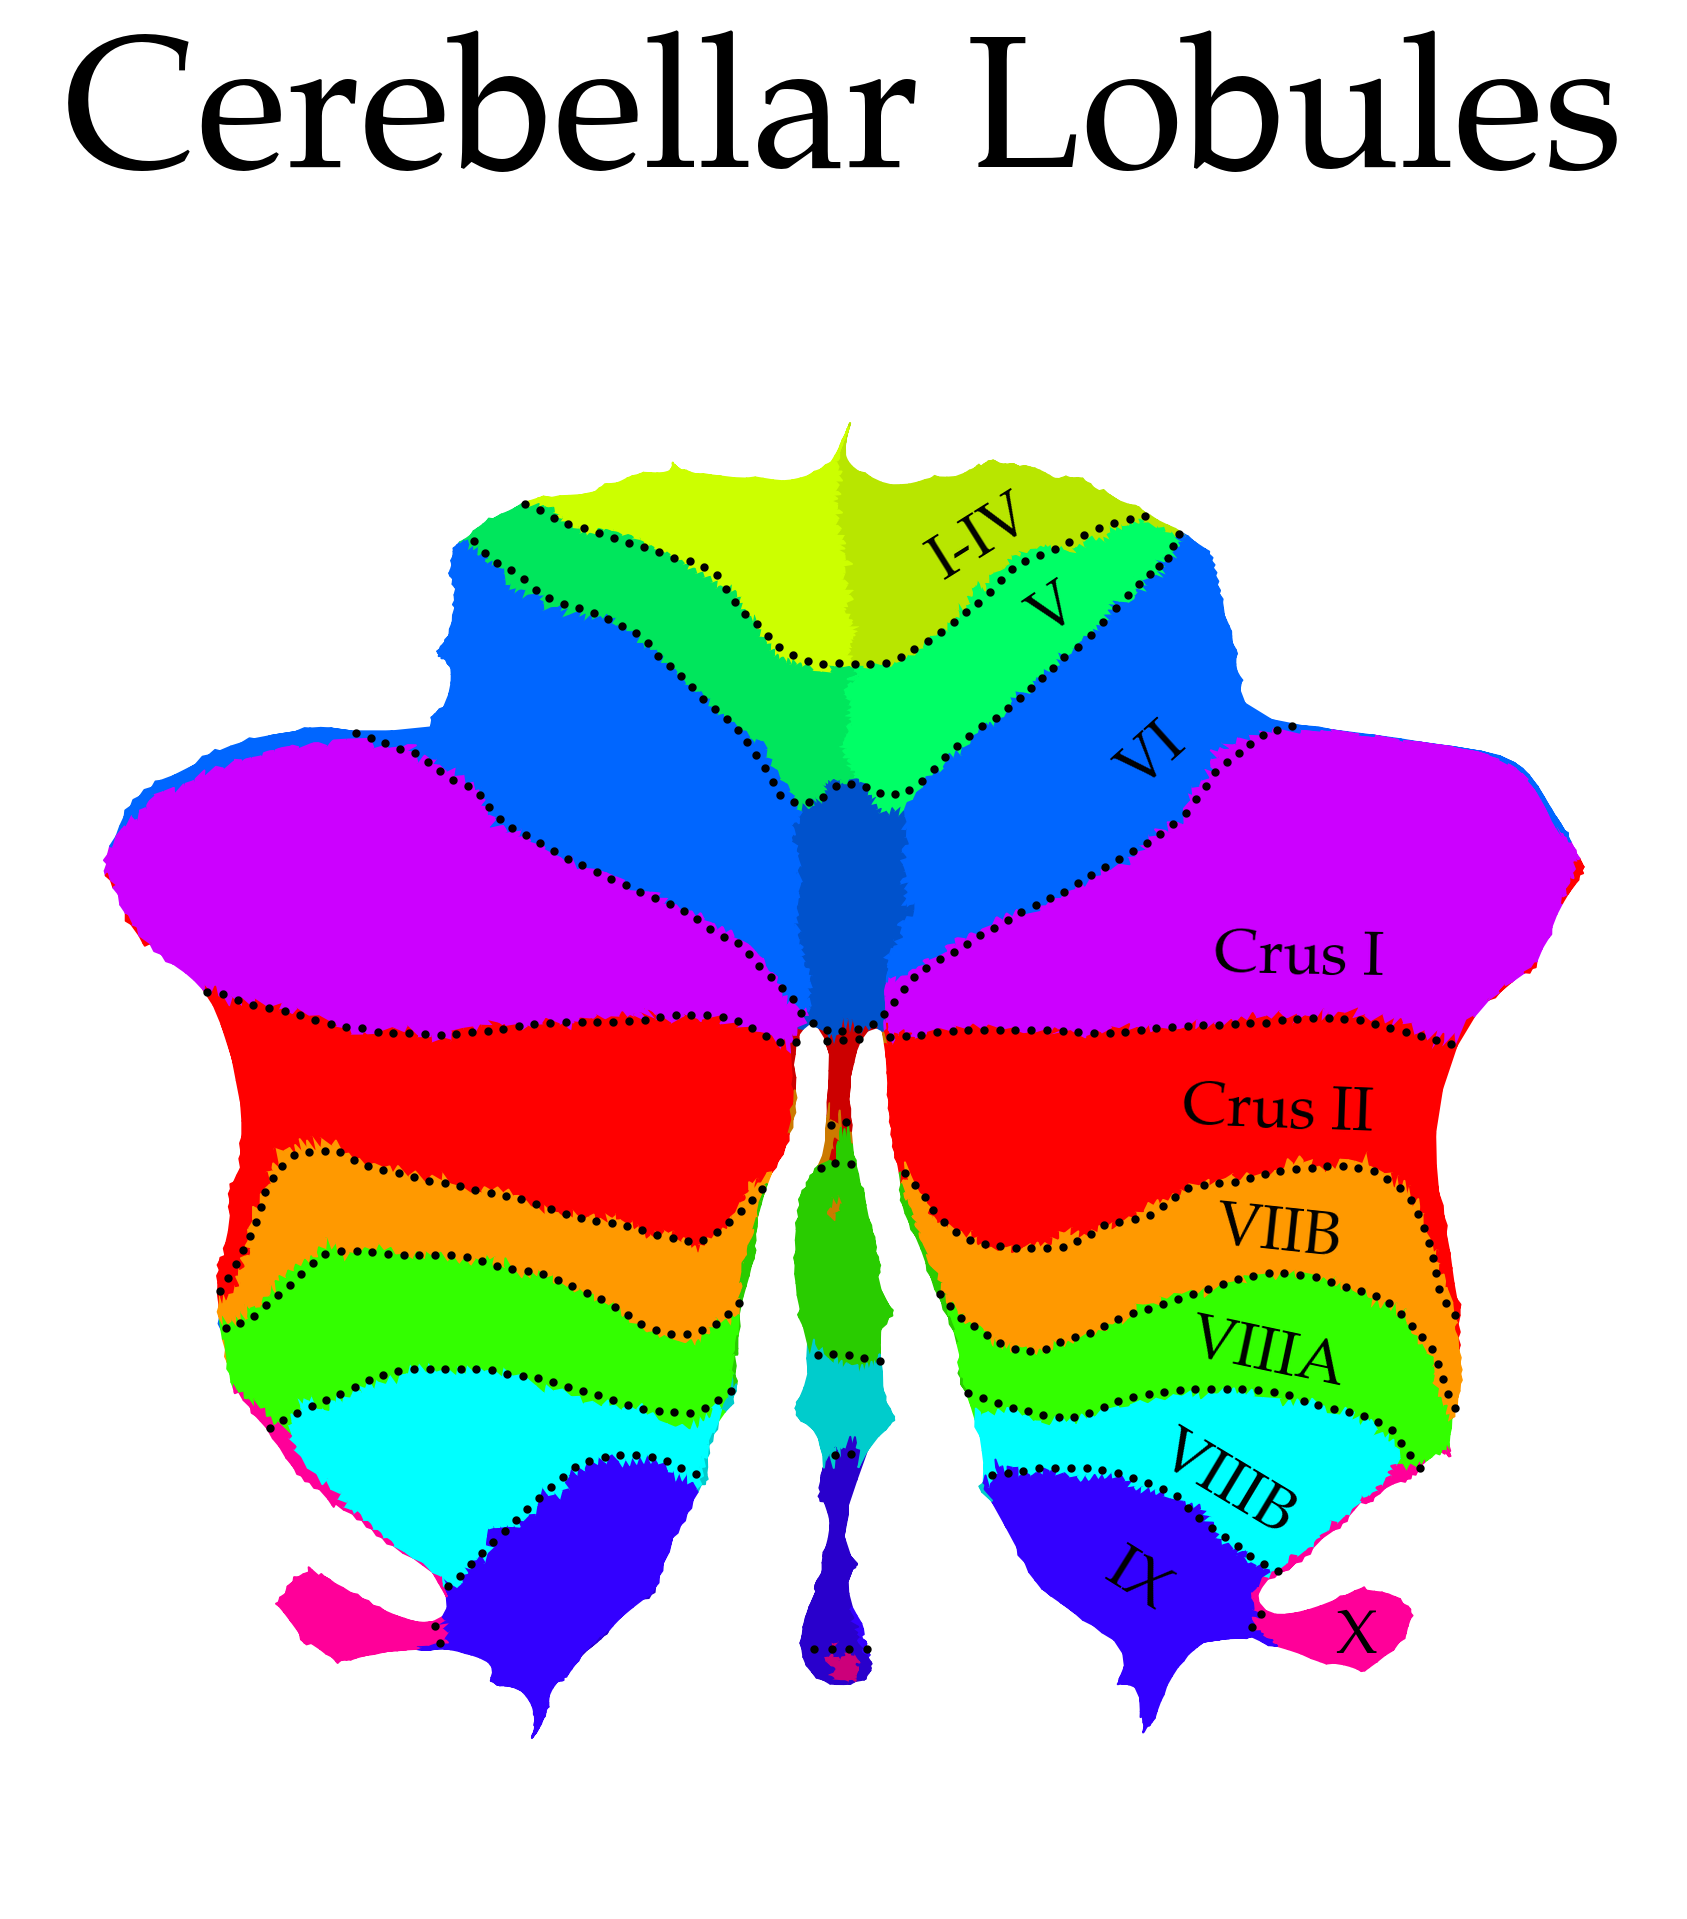

In [60]:
# Load the GIFTI file
G = nibabel.load(os.path.join(INPUT_DIR, 'maps/Lobules.label.gii'))

# Plot the flatmap
flatmap_plot = SUITPy.flatmap.plot(G, overlay_type='label')

# Set title
flatmap_plot.set_title('Cerebellar Lobules', fontsize=45, y=1.05)

# Manually add the lobule labels (took some trial-and-error)
manual_labels = ['I-IV', 'V', 'VI', 'Crus I', 'Crus II', 'VIIB', 'VIIIA', 'VIIIB', 'IX', 'X']
manual_label_positions = [(0.585, 0.835), (0.63, 0.79), (0.69, 0.70), (0.78, 0.575), (0.767, 0.48), (0.767, 0.405), (0.760, 0.330), (0.735, 0.25), (0.68, 0.190), (0.815, 0.155)]
manual_label_rotations = [32, 34, 42, -1, -2, -6, -12, -31, -32, 0]

for label, position, rotation in zip(manual_labels, manual_label_positions, manual_label_rotations):
    flatmap_plot.text(position[0], position[1], label, fontsize=15, ha='center', va='center', transform=flatmap_plot.transAxes, rotation=rotation, fontweight='bold')

plt.savefig(os.path.join(figure_dir, '6a_Cerebellar_lobules.png'), dpi = 300)

plt.show()


# For the main Figure, we create common figures for all subdomain MACMs
#### 1. Seeds (Supplementary); 2. Cerebellar MACM results; 3. Subcortical MACM results; 4. Cerebral MACM results.

In [61]:
# 1. Cerebellar Seeds
# Define the number of rows and columns for the subplot grid
num_rows = 1
num_cols = 4
num_subdomains_to_plot = 4  # Set the number of subdomains to plot

# Create a new figure with the specified size
fig = plt.figure(figsize=(20, 4))

# Loop over each domain
for domain in domains:
    # Create a grid layout for subplots within the current domain's section
    grid = plt.GridSpec(num_rows, num_cols, figure=fig)
    # Loop over subdomains with both index and value
    for i, subdomain in islice(enumerate(subdomain_order), num_subdomains_to_plot):
        # Calculate the row and column indices within the domain's grid section
        row = i // num_cols
        col = i % num_cols 
        # Construct the combined key for accessing the surf dictionary
        # combined_key = f"{domain}.{subdomain}"
        # Construct the file path for the current subdomain
        cluster_nifti = os.path.join(OUTPUT_DIR, f'SALE/{domain}/{subdomain}/corr_cluster_h-001_k-50_mask-D2009_MNI_z.nii.gz')
        # Check if the file path exists
        if os.path.exists(macm_nifti):
            cluster_bin = nilearn.image.binarize_img(cluster_nifti) # Binarize.
            # Create a subplot within the current domain's grid section
            ax = fig.add_subplot(grid[row, col])
            surface_map = SUITPy.flatmap.vol_to_surf(cluster_bin, space = 'SPM').squeeze(), # Stats and space.
            surface_data = surface_map[0]  # Get the surface map data (NumPy array)
            binarized_surface_data = np.where(surface_data > 0, 1, 0) # We need to binarize again, since stats = 'nanmean' (default) averages across 6 GM depths and thus efectively removes binarization in our maps.
            # Plot the flatmap for the current subdomain
            SUITPy.flatmap.plot(binarized_surface_data, colorbar=False, cmap='Paired', underscale = [-0.3, 1],  new_figure=False)
            # Customize subplot title and text
            ax.set_title(filtered_subdomain_labels[subdomain], fontsize=25, y=1.01)
            ax.text(0.5, -0.05, f'N = {stats.loc[subdomain, "n_exp"]} Experiments', fontsize=14, ha='center', va='center', transform=ax.transAxes)
        else:
            print(f"File path does not exist for subdomain: {subdomain}. Skipping...")
# Adjust layout to prevent overlap
plt.tight_layout()
# Save the figure
fig.savefig(os.path.join(supplementary_dir, 'S15b_Cerebellar_Seeds_Subd-h001_k50.png'), bbox_inches='tight')

# Show the plot
plt.show()

File path does not exist for subdomain: Cognition.Memory.Working. Skipping...
File path does not exist for subdomain: Perception.Vision. Skipping...
File path does not exist for subdomain: Action.Execution.Speech. Skipping...
File path does not exist for subdomain: Action.Execution. Skipping...
File path does not exist for subdomain: Cognition.Memory.Working. Skipping...
File path does not exist for subdomain: Perception.Vision. Skipping...
File path does not exist for subdomain: Action.Execution.Speech. Skipping...
File path does not exist for subdomain: Action.Execution. Skipping...
File path does not exist for subdomain: Cognition.Memory.Working. Skipping...
File path does not exist for subdomain: Perception.Vision. Skipping...
File path does not exist for subdomain: Action.Execution.Speech. Skipping...
File path does not exist for subdomain: Action.Execution. Skipping...
File path does not exist for subdomain: Cognition.Memory.Working. Skipping...
File path does not exist for subdo

<Figure size 6000x1200 with 0 Axes>

File path does not exist for subdomain: Cognition.Memory.Working. Skipping...
File path does not exist for subdomain: Perception.Vision. Skipping...
File path does not exist for subdomain: Perception.Vision. Skipping...
File path does not exist for subdomain: Action.Execution.Speech. Skipping...
File path does not exist for subdomain: Action.Execution. Skipping...
File path does not exist for subdomain: Cognition.Memory.Working. Skipping...
File path does not exist for subdomain: Perception.Vision. Skipping...
File path does not exist for subdomain: Action.Execution.Speech. Skipping...
File path does not exist for subdomain: Action.Execution. Skipping...
File path does not exist for subdomain: Cognition.Memory.Working. Skipping...
File path does not exist for subdomain: Perception.Vision. Skipping...
File path does not exist for subdomain: Action.Execution.Speech. Skipping...
File path does not exist for subdomain: Action.Execution. Skipping...
File path does not exist for subdomain: C

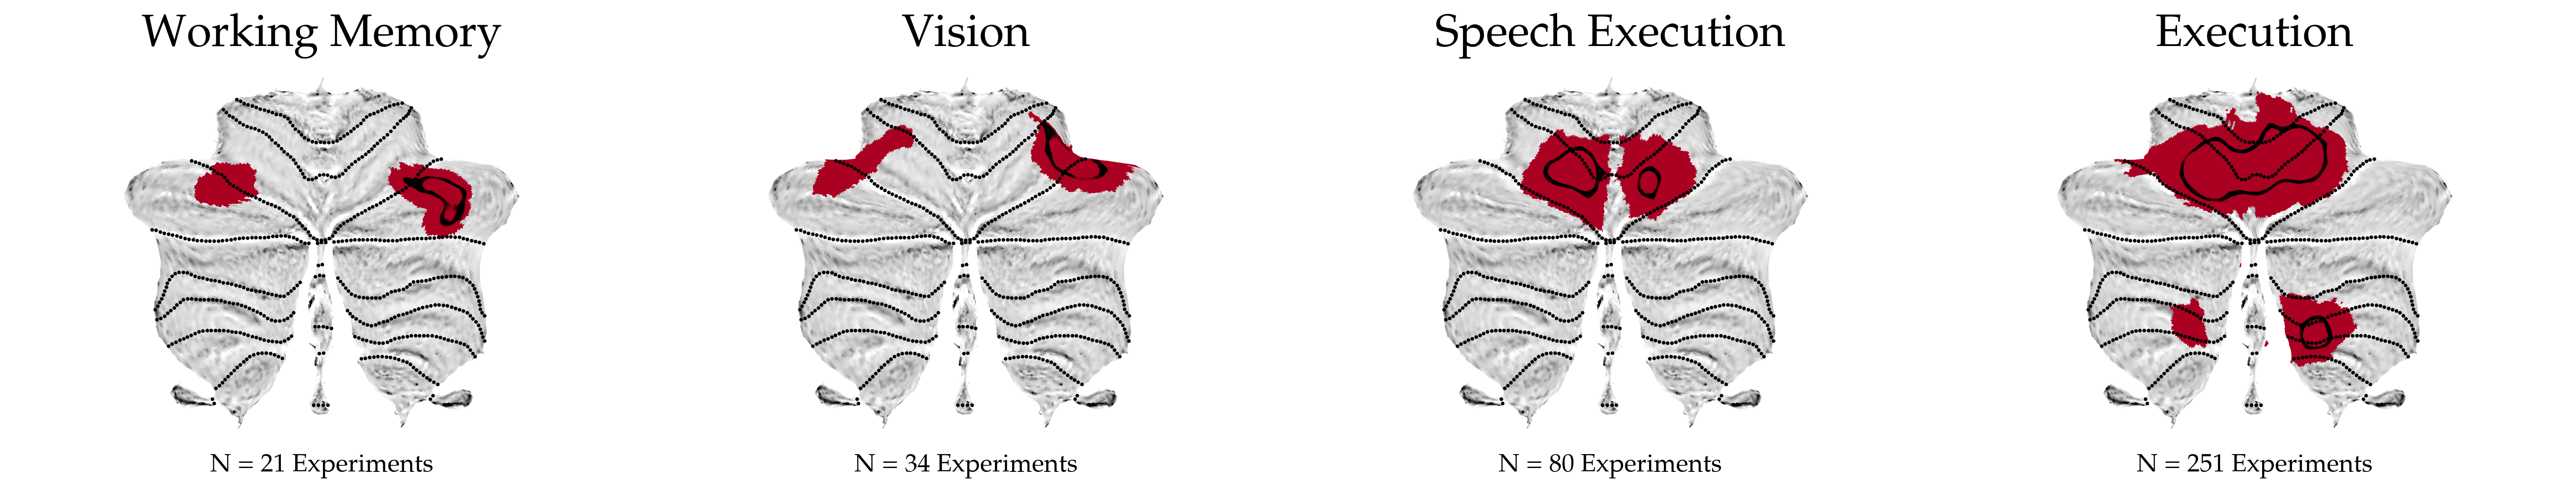

In [62]:
# 2. Cerebellar MACM results

# Define the number of rows and columns for the subplot grid
num_rows = 1
num_cols = 4
num_subdomains_to_plot = 4  # Set the number of subdomains to plot

# Create a new figure with the specified size
fig = plt.figure(figsize=(20, 4))

# Loop over each domain
for domain in domains:
    # Create a grid layout for subplots within the current domain's section
    grid = plt.GridSpec(num_rows, num_cols, figure=fig)

    # Loop over subdomains with both index and value
    for i, subdomain in islice(enumerate(subdomain_order), num_subdomains_to_plot):
        # Calculate the row and column indices within the domain's grid section
        row = i // num_cols  # Integer division to determine the row index
        col = i % num_cols   # Modulus operation to determine the column index

        # Construct the combined key for accessing the surf dictionary
        # combined_key = f"{domain}.{subdomain}"
        
        # Construct the file path for the current subdomain
        macm_nifti = os.path.join(OUTPUT_DIR, f'SALE/{domain}/{subdomain}/corr_cluster_h-001_k-50_mask-D2009_MNI_z_macm/corr_cluster_k-50_z.nii.gz')

        # Check if the file path exists
        if os.path.exists(macm_nifti):
            macm_bin = nilearn.image.binarize_img(macm_nifti) # Binarize.
            # Create a subplot within the current domain's grid section
            ax = fig.add_subplot(grid[row, col])

            surface_map = SUITPy.flatmap.vol_to_surf(macm_bin, space = 'SPM').squeeze(), # Stats and space.

            # Overlay the cluster borders on top
            ax.plot(subbd_surf_cluster_boundary_coords['SALE'][subdomain][:, 0], subbd_surf_cluster_boundary_coords['SALE'][subdomain][:, 1], # Add borders if desired.
                    color='black', marker='.', linestyle=None, markersize=0.01, linewidth=0)
            

            surface_data = surface_map[0]  # Get the surface map data (NumPy array)
            binarized_surface_data = np.where(surface_data > 0, 1, 0) # We need to binarize again, since stats = 'nanmean' (default) averages across 6 GM depths and thus efectively removes binarization in our maps.
            
            # Plot the flatmap for the current subdomain
            SUITPy.flatmap.plot(binarized_surface_data, colorbar=False, cmap=custom_cmap, underscale = [-0.3, 1],  new_figure=False)

            # Customize subplot title and text
            ax.set_title(subdomain_labels[subdomain], fontsize=25, y=1.01)
            ax.text(0.5, -0.05, f'N = {stats.loc[subdomain, "n_exp"]} Experiments', fontsize=14, ha='center', va='center', transform=ax.transAxes)

        else:
            print(f"File path does not exist for subdomain: {subdomain}. Skipping...")


# Adjust layout to prevent overlap
plt.tight_layout()

# Decide if you want to save the figure
fig.savefig(os.path.join(figure_dir, '6b_Cerebellum_MACM-Subd-h001_k50_Figure_wborders'), bbox_inches='tight')

# Show the plot
plt.show()

# 3. Subcortical results

100%|█████████████████████████████████████████████████████████████████████████████████| 12/12 [00:26<00:00,  2.19s/it]


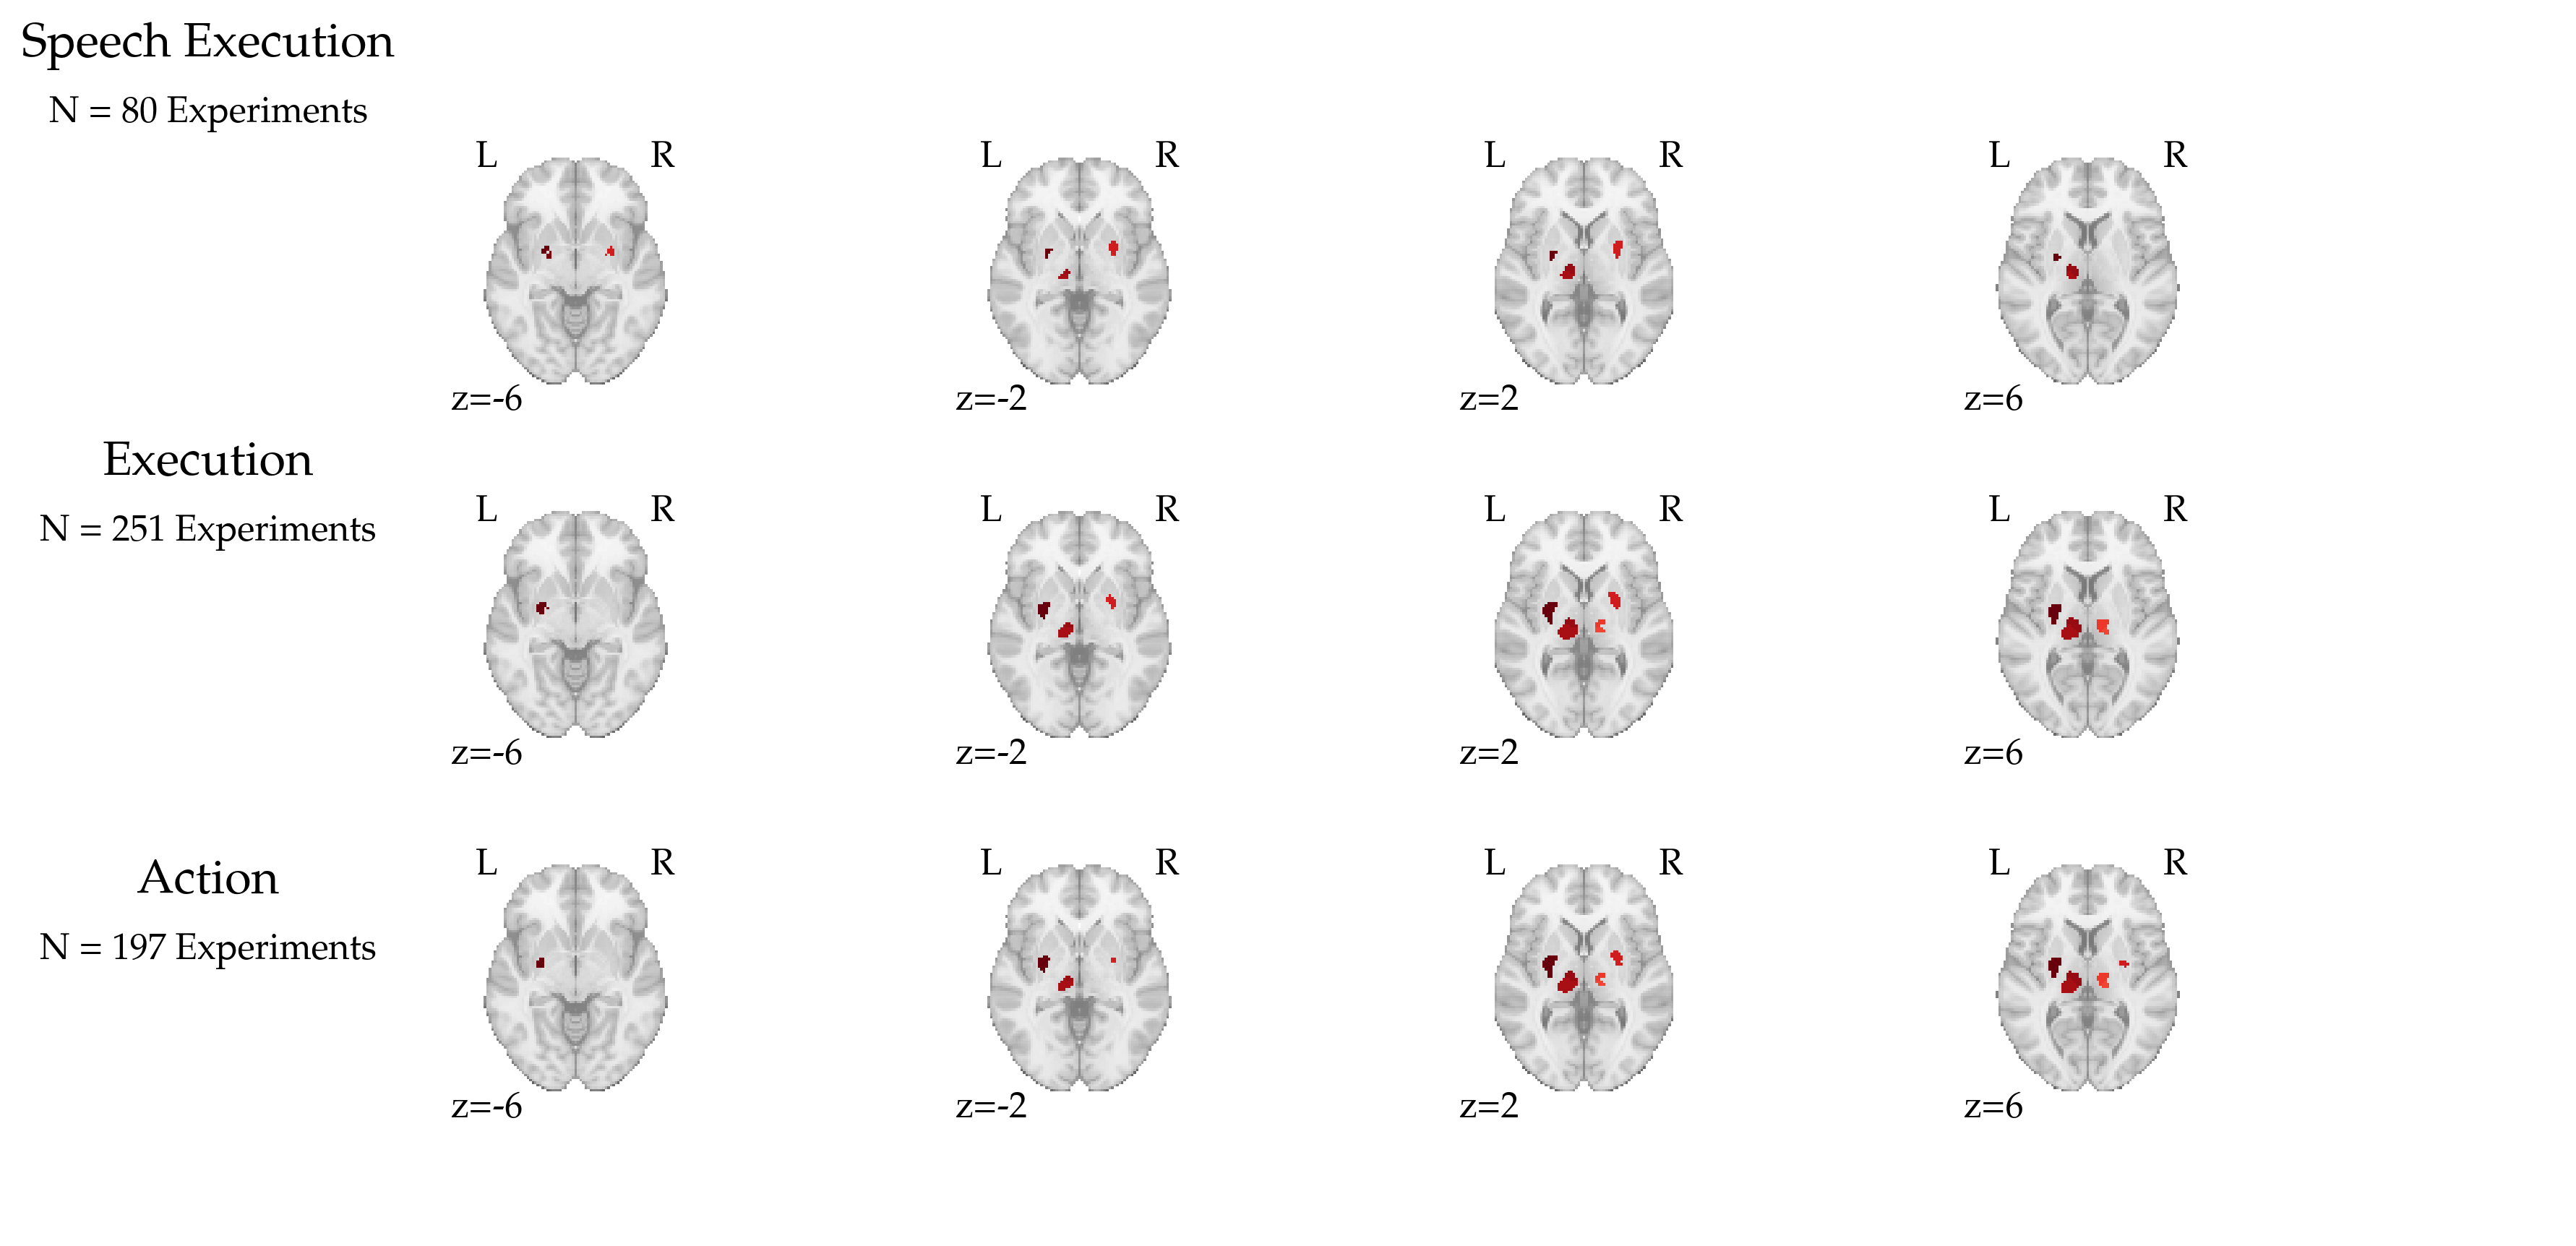

In [63]:
# Get MACM paths
macm_paths = sorted(glob.glob(
    '/data/project/cerebellum_ale/output/SALE/*/*/corr_cluster_h-001_k-50_mask-D2009_MNI_z_macm/corr_cluster_k-50_z.nii.gz'
))

# Create an empty list to store valid MACM maps
valid_macm_maps = []

# Loop over all MACM maps to plot them
for i, macm_path in enumerate(tqdm(macm_paths)):
    # Extract the subdomain name
    subbd = (macm_path
             .split('/corr_cluster_h-001_k-50_mask-D2009_MNI_z_macm/corr_cluster_k-50_z.nii.gz')[0]
             .split('/data/project/cerebellum_ale/output/SALE/')[1]
             .split('/')[1]
            )
    # Load the MACM maps
    macm_img = nilearn.image.load_img(macm_path)
    # Binarize it
    macm_bin = nilearn.image.binarize_img(macm_img)
    # Apply the subcortex mask to the binarized MACM map (effectively restricting the MACM map to the subcortex)
    macm_bin_crop = nilearn.image.math_img('img1 * img2', img1=macm_bin, img2=tian_2mm)
    # Convert the cropped MACM map to a numpy array and check if there is any data in there
    macm_bin_crop_data = macm_bin_crop.get_fdata()
    if np.any(macm_bin_crop_data):  # Only plot if there is data
        # Add valid maps + their subdomain name to the list
        valid_macm_maps.append((macm_bin_crop, subbd))
# Determine the number of valid plots and create the figure
n_plots = len(valid_macm_maps)
n_cols = 1  # Number of columns (adjust as needed)
n_rows = int(np.ceil(n_plots / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 6))
axes = axes.flatten()  # Flatten the axes array for easy indexing
# Plot the valid MACM maps
for i, (macm_bin_crop, subbd) in enumerate(valid_macm_maps):
    # Get the nicer label for the current subdomain
    label = subdomain_labels.get(subbd, subbd)
    # Plot the MACM map on the corresponding subplot
    nilearn.plotting.plot_stat_map(
        macm_bin_crop, 
        cmap='Reds', 
        display_mode='z', 
        cut_coords=[-6, -2, 2, 6],  # Adjust the slices as needed
        title=None,  # Disable the title in plot_stat_map
        axes=axes[i],
        colorbar=False
    )
    # Set the title using Matplotlib to avoid the black box background
    axes[i].set_title(f"{label}", size=16, x= -0.15, y=1.20, fontweight='bold')
    # Add text label for the sample size
    axes[i].text(-0.15, 1.05, f'N = {stats.loc[subbd, "n_exp"]} Experiments', fontsize=12, ha='center', va='center', transform=axes[i].transAxes)

# Remove any empty subplots if the number of valid maps is less than the grid size
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig(os.path.join(figure_dir, '6c_Subcortex_MACM-Subd-h001_k50_Figure.png'), bbox_inches='tight', dpi=300)

plt.show()


# 4. Cerebral results

We combine existing plots

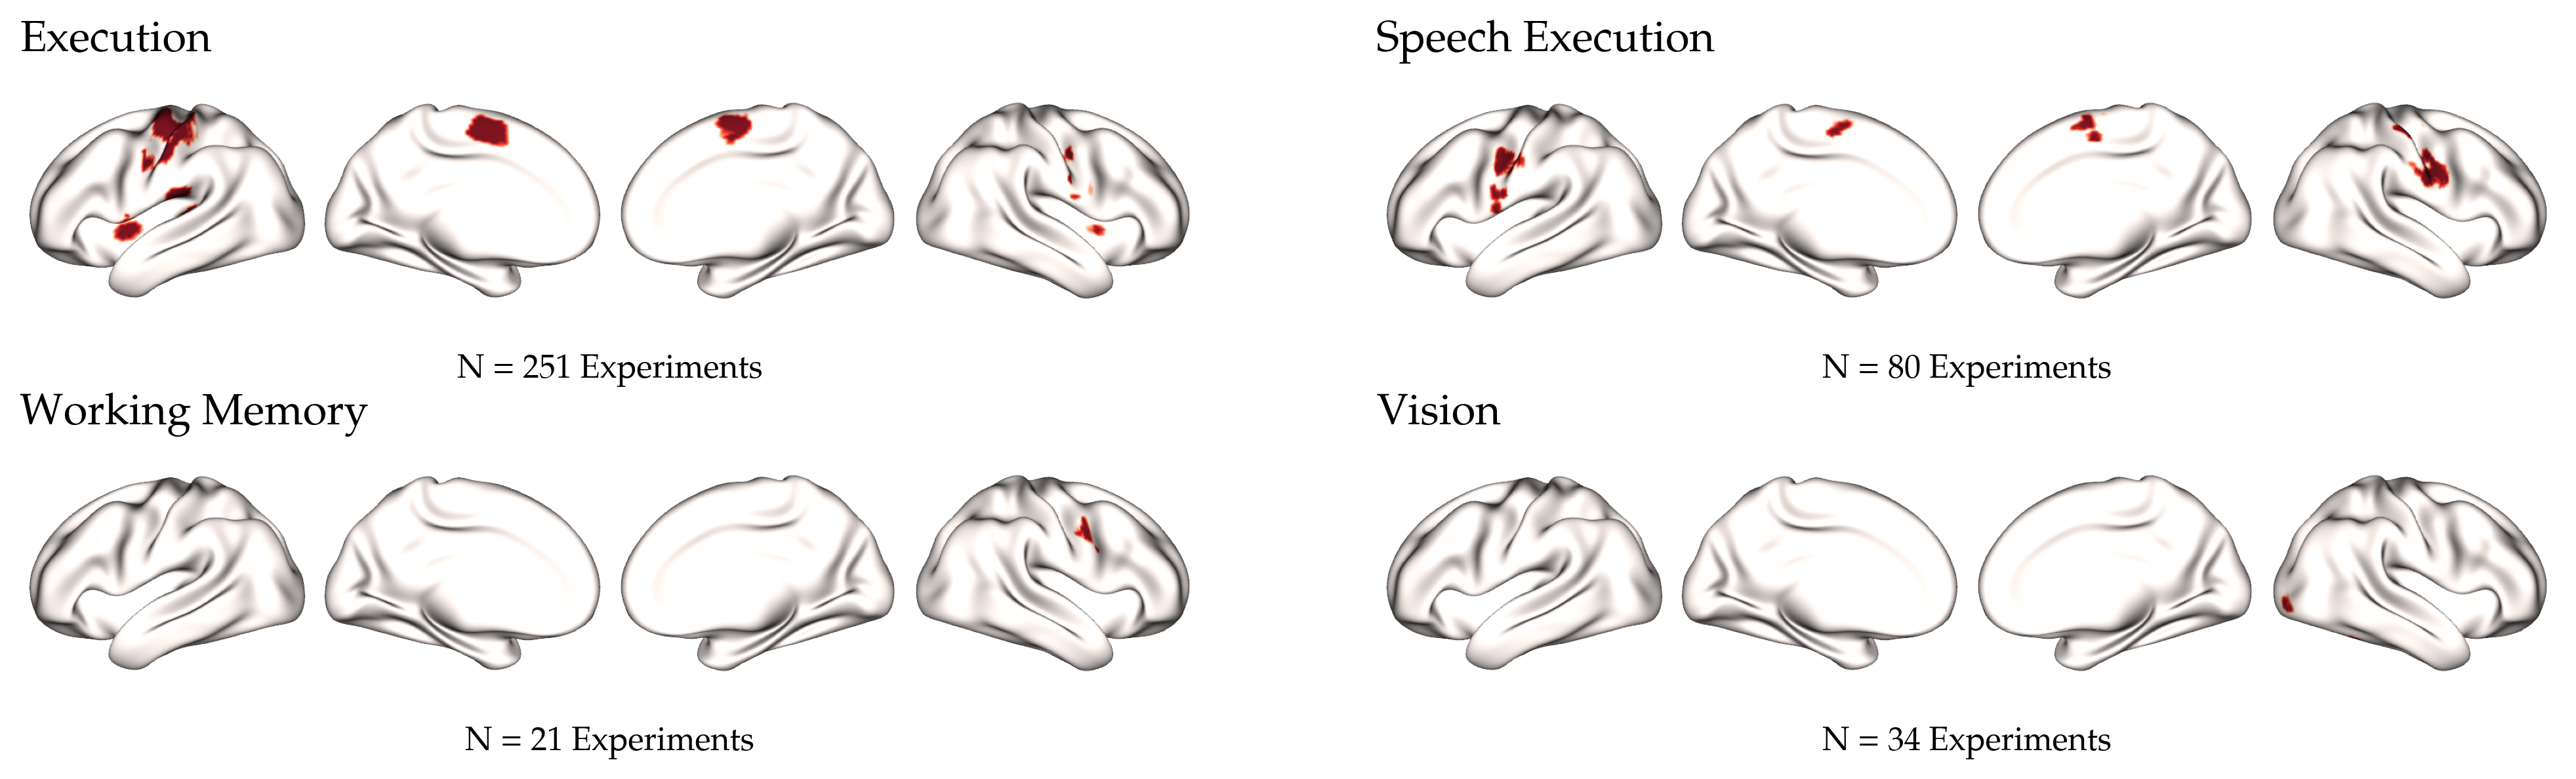

In [64]:
# Initialize lists to collect plot files, labels, and sample keys
plot_files = []
plot_labels = []
sample_size_keys = []  # To fetch sample sizes from stats DataFrame

# Iterate through each domain and subdomain
for domain in domains:
    for subdomain in filtered_subdomains:
        # Construct the file path
        plot_path = os.path.join(supplementary_dir, f'Cerebrum/{domain}/{subdomain}/{subdomain}_MACM_Cerebral-Cortex-Surface_p001_K50-binarized.png')
        
        # Check if the plot file exists and add to lists if so
        if os.path.exists(plot_path):
            plot_files.append(plot_path)
            
            # Get the label from filtered_subdomain_labels or use subdomain if missing
            full_label = f"{subdomain}"
            nice_label = filtered_subdomain_labels.get(full_label, subdomain)
            plot_labels.append(nice_label)
            
            # Create a sample size key for stats lookup
            sample_size_keys.append(full_label.replace(' ', '.'))

# Calculate number of plots, rows, and columns
n_plots = len(plot_files)
n_cols = 2
n_rows = int(np.ceil(n_plots / n_cols))

# Set up the figure and subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(14, 2 * n_rows))
axes = axes.flatten()

# Loop through plot files, labels, and sample size keys
for i, (plot_file, label, sample_key) in enumerate(zip(plot_files, plot_labels, sample_size_keys)):
    img = plt.imread(plot_file)  # Read image
    axes[i].imshow(img)
    axes[i].axis('off')

    # Fetch the number of experiments for the current subdomain from stats
    num_experiments = stats.loc[sample_key, "n_exp"] if sample_key in stats.index else 'N/A'

    # Set title and experiment count for each plot
    axes[i].set_title(f"{label}", size=16, loc='left', y=0.95, fontweight='bold')
    axes[i].text(0.5, -0.1, f'N = {num_experiments} Experiments', fontsize=12, ha='center', transform=axes[i].transAxes)

# Remove any unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Save the figure and show it
plt.tight_layout()
plt.savefig(os.path.join(figure_dir, '6d_Cerebrum_MACM-Subd-h001_k50_Figure.png'), bbox_inches='tight', dpi=300)
plt.show()